## Assignment 2

# 1. Summary

In this Assignment, we elected to develop three seperate Deep Learning Classifiers, for the purpose of identifying greyscale handwritten letters and numbers. We employed 3 models to achieve this:

1. Convolutional Neural Network

2. ResNet

3. Vision Transformer

# 2. Dataset description and Overview
The dataset used for this assignment is a sample from [EMNIST handwritten character dataset - ByClass](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of 814,255+ 28 by 28 images with character labels. This smaller sample set can be downloaded from the Google Drive link provided in the assignment specification. The dataset consists of 120000 amount images, of which 100,000 is split into a test set, which was further divided into a validation set after pre-processing, and a testing set of 20,000.

EMNIST - is an Extension of the classical MNIST dataset, hense the name - EMNIST.

Data Samples are catagorised into 62 classes that are unbalanced (see class distribution figure below)

- 0-9: Digits from 0-9

- 10-36: Capital Letters

- 37 - 62: Lowercase Letters

Below are visual examples of the dataset, showcasing a small number from each of the 3 categories.

In [2]:
!pip install keras==3.4.1
!pip install seaborn
!pip install tensorflow[and-cuda]
!pip install scikit-learn==1.5.2
!pip install scipy==1.12.0
!pip install numpy==1.26.4


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 90.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 66.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 36.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 82.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 KB 67.9 MB/s eta 0:00:00
  Using cached nvidia_nvjitlink_cu12-12.3.101-py3-none-manylinux1_x86_64.whl (20.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 44.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 58.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/41

In [3]:
!pip install --upgrade keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # Digits (0-9)
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',  # Letters (10-19)
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',  # Letters (20-29)
    'U', 'V', 'W', 'X', 'Y', 'Z',                      # Letters (30-35)
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r',  # Lowercase that aren't merged (36-45)
    't'                                                 # Remaining lowercase letter (46)
]


def display_conf(conf_matrix):
    # Get the number of classes
    num_classes = conf_matrix.shape[0]

    # Create character labels using the label_mapping
    char_labels = [label_mapping[i] for i in range(num_classes)]

    plt.figure(figsize=(20, 15))  # Increase the size of the figure for readability
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=char_labels, yticklabels=char_labels,
                cbar=False, annot_kws={"size": 14})
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Labels', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent cutting off labels
    plt.show()



2024-10-14 21:44:32.882335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 21:44:32.893501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 21:44:32.897005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 21:44:32.905650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 21:44:33.464698: W tensorflow/compiler/tf2

In [6]:
import pickle
import os
import sys
#from google.colab import drive
#drive.mount('/content/drive')
print(os.getcwd())

content_path = ''

train_dict = pickle.load(open(os.path.join(content_path, 'emnist_train.pkl'), 'rb'))
test_dict = pickle.load(open(os.path.join(content_path, 'emnist_test.pkl'), 'rb'))

# Extract the images and labels from the dictionaries
train_images = train_dict['data']
train_labels = train_dict['labels']
test_images = test_dict['data']
test_labels = test_dict['labels']
print("Testing images shape:", test_images.shape)
print("Training images shape:", train_images.shape)
print("Training Labels shape:", train_labels.shape)


/home/calvin/COMP4318_ASSN2
Testing images shape: (20000, 28, 28)
Training images shape: (100000, 28, 28)
Training Labels shape: (100000,)


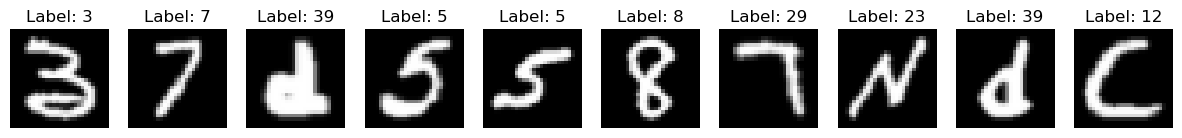

In [7]:
# Number of images to display
num_images = 10

# Create a figure and axes for the grid
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate through the sample images
for i in range(num_images):
  # Select a random image
  random_index = np.random.randint(0, len(train_images))
  image = np.rot90(train_images[random_index].reshape(28, 28), k=3)  # Rotate 270 degrees (90 * 3)
  image = np.fliplr(image)  # Flip the image horizontally

  # Display the image
  axes[i].imshow(image, cmap='gray')
  axes[i].axis('off')

  #Add the class label above the image
  axes[i].set_title(f"Label: {train_labels[random_index]}", fontsize=12)

plt.show()


### Distribution

As evidenced below, there is an imbalance in the amount of classes, of which is was essential for us to take into account when training our models.

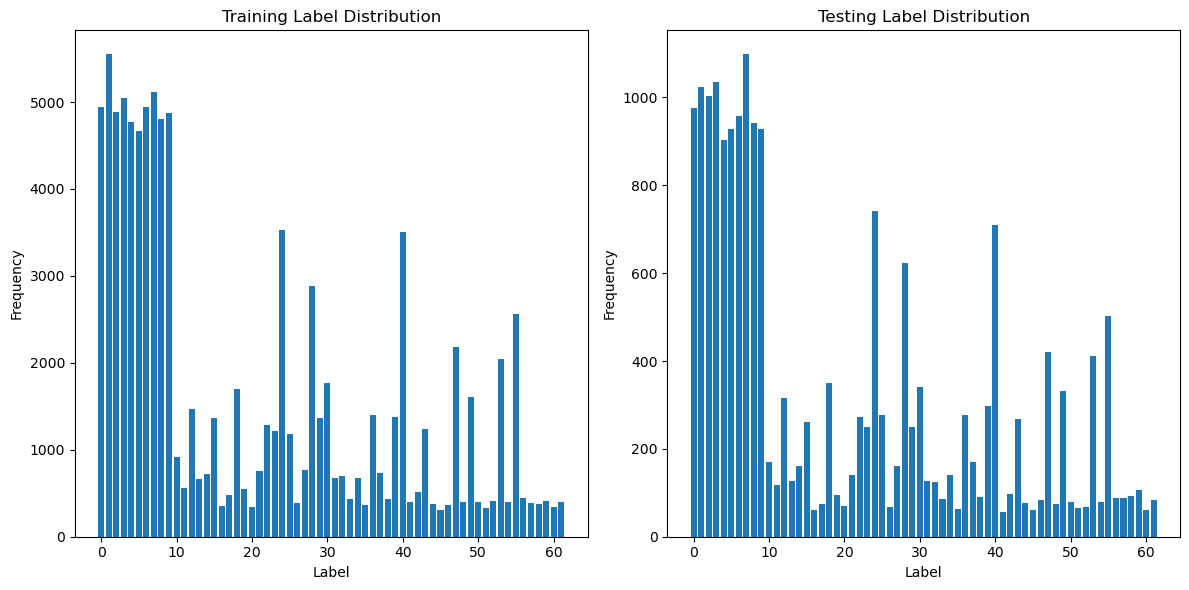

In [8]:
# Calculate the frequency of each label in the training set
train_label_counts = {}
for label in train_labels:
  if label not in train_label_counts:
    train_label_counts[label] = 0
  train_label_counts[label] += 1

# Calculate the frequency of each label in the testing set
test_label_counts = {}
for label in test_labels:
  if label not in test_label_counts:
    test_label_counts[label] = 0
  test_label_counts[label] += 1


# Plot the histogram of training labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot the histogram of testing labels
plt.subplot(1, 2, 2)
plt.bar(test_label_counts.keys(), test_label_counts.values())
plt.title('Testing Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# 3. Data Preparation

Requred data is provided in a .zip file, which is to be unzipped and then placed into the project folder.

- `emnist_test.pkl`: Contains a Dictionary of 20,000 Testing Images and Labels

- `emnist_train.pkl`: Contains a Dictionary of 100,000 Training Images and Labels


## 3.1 Merging Classes

Due to the similarities of Uppercase and Lowercase letters, as [suggested](https://arxiv.org/pdf/1702.05373v1) by the creators of the dataset specific images will be merged, for example lowercase 'k' is similar to uppercase "K"


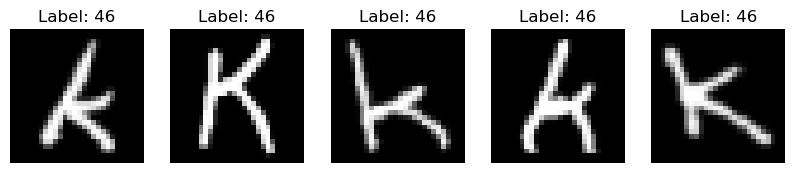

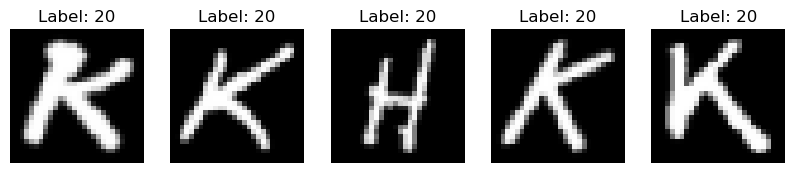

In [9]:
def display_images_by_label(images, labels, target_label, num_samples=5):
    # Find the indices of images with the target label
    indices = np.where(labels == target_label)[0]

    # Display a few images with the specified label
    if len(indices) == 0:
        print(f"No images found for label {target_label}")
        return

    # Limit to the specified number of samples
    indices = indices[:num_samples]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        # Rotate and then flip it horizontally
        rotated_image = np.fliplr(np.rot90(images[idx].reshape(28, 28), k=3))

        # Display the rotated and flipped image
        plt.imshow(rotated_image, cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

display_images_by_label(train_images, train_labels, target_label=46, num_samples=5)  # Display lowercase 'c'
display_images_by_label(train_images, train_labels, target_label=20, num_samples=5)  # Display uppercase 'C'

From the above figure we can also see that the dataset it not perfect, the 3rd image on the bottom set is clearly an H. As such it is imperative that we incorporate means of mitigating other potential mislabels in the dataset, such as incorporating label smoothing (assigning probabilities to predictions - done via softmax), or data augmentation, as well as normalisation.

In [10]:
merge_dictionary = {
        38: 12,  # 'c' -> 'C'
        44: 18,  # 'i' -> 'I'
        45: 19,  # 'j' -> 'J'
        46: 20,  # 'k' -> 'K'
        47: 21,  # 'l' -> 'L'
        48: 22,  # 'm' -> 'M'
        50: 24,  # 'o' -> 'O'
        51: 25,  # 'p' -> 'P'
        54: 28,  # 's' -> 'S'
        56: 30,  # 'u' -> 'U'
        57: 31,  # 'v' -> 'V'
        58: 32,  # 'w' -> 'W'
        59: 33,  # 'x' -> 'X'
        60: 34,  # 'y' -> 'Y'
        61: 35   # 'z' -> 'Z'
    }

def merge_labels(labels, merge_dictionary):
    merged_labels = np.copy(labels)
    for old_label, new_label in merge_dictionary.items():
        merged_labels[labels == old_label] = new_label
    return merged_labels

#Step 0
# Merge the labels
train_labels = merge_labels(train_labels, merge_dictionary)
test_labels = merge_labels(test_labels, merge_dictionary)
#Print Number of unique labels
print("Number of unique labels in the training set:", len(np.unique(train_labels)))
print("Number of unique labels in the testing set:", len(np.unique(test_labels)))

Number of unique labels in the training set: 47
Number of unique labels in the testing set: 47


In [11]:
# Full list of labels for the merged EMNIST dataset
def map_labels_to_characters(label_indices):
    return [label_mapping[index] for index in label_indices]

sample_labels = [0, 12, 35, 46]
mapped_characters = map_labels_to_characters(sample_labels)
print("Mapped characters:", mapped_characters)

Mapped characters: ['0', 'C', 'Z', 't']


## 3.2 Further Preprocessing

The below cell is where key steps of the preprocessing occurs, in order

1. Label Encoding: Done to transform the labels into a meaningful format for our classifiers to work with

2. Normalisation: Done to improve model convergence as well as training stability, provides consistent input data  (for more information return to report)

3. Rotating and Flipping

4. Reshaping to ensure data is in appropriate format

5. Creation of a validation set

6. Data Augmentation step - due to aformentioned reasons as well as unbalanced class distributions

7. Computation of class weights for training, to also mitigate class imbalance

8. Type conversion

In [12]:
# Step 1: Label Encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Step 2: Normalize the pixel values (0-255) to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

def rotate_and_flip(images):
    return np.array([np.fliplr(np.rot90(img.reshape(28, 28), k=3)) for img in images])

train_images = rotate_and_flip(train_images)
test_images = rotate_and_flip(test_images)

# Step 3: Reshape the images for model input
N_train = train_images.shape[0]  # Number of training images
N_test = test_images.shape[0]    # Number of testing images

# Reshape the images to (N, 28, 28, 1)
train_images = train_images.reshape(N_train, 28, 28, 1)
test_images = test_images.reshape(N_test, 28, 28, 1)

# Step 4: Validation set split
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, train_size=0.9, random_state=42)

# Step 5: Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
    zoom_range=0.1           # Randomly zoom into images by up to 10%
)

# No augmentation for validation data, just rescaling
valid_datagen = ImageDataGenerator()

# Step 6: Fit the data generator on the training images (optional)
train_datagen.fit(X_train)

# Step 7: Class Rebalancing
# Compute class weights to account for class imbalance
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Step 8: Convert data to appropriate types
X_train = X_train.astype('float32')
y_train = y_train.astype('int64')
X_valid = X_valid.astype('float32')
y_valid = y_valid.astype('int64')

# Print summary of preprocessing steps
print("Train images shape (after reshaping):", X_train.shape)
print("Validation images shape:", X_valid.shape)
print("Test images shape (after reshaping):", test_images.shape)
print("Class weights for balancing:", class_weights_dict)

Train images shape (after reshaping): (90000, 28, 28, 1)
Validation images shape: (10000, 28, 28, 1)
Test images shape (after reshaping): (20000, 28, 28, 1)
Class weights for balancing: {0: 0.42954096388992297, 1: 0.38251969976453787, 2: 0.4321583428168081, 3: 0.421968624288514, 4: 0.45098766298193044, 5: 0.4541967782308531, 6: 0.43235349221523517, 7: 0.414120591916366, 8: 0.44357044637972587, 9: 0.43372448856654056, 10: 2.33523611831863, 11: 3.732736095558044, 12: 1.1283993028999861, 13: 3.223726627981947, 14: 2.9459901800327333, 15: 1.5695849319846529, 16: 5.946874587022598, 17: 4.474050507059057, 18: 1.0234599770290094, 19: 2.486874827300359, 20: 3.0638297872340425, 21: 0.7206976353109811, 22: 1.2673021952490249, 23: 1.736077621959453, 24: 0.5440038684719536, 25: 1.435452486522696, 26: 5.733214422219391, 27: 2.7711919204360007, 28: 0.6502185456778529, 29: 1.5442690459849004, 30: 0.9603277918862972, 31: 2.015677491601344, 32: 1.9539730785931393, 33: 2.5772457833395377, 34: 2.11824515

## 4. Model 1 - CNN
Defining Initial CNN to Expound upon

In [12]:
# Define the model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU
from tensorflow.keras import layers

keras.backend.clear_session()


model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Input shape for EMNIST data


    # First Conv Block
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Second Conv Block
    keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Third Conv Block
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    # Fourth Conv Block
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten Layer
    keras.layers.Flatten(),

    # Fully Connected Layers
    keras.layers.Dense(128),  # No activation here, add as a separate layer
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation="softmax"),  # Output layer for classification
])

model.summary()

I0000 00:00:1728901480.063384 1841410 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728901480.063543 1841410 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728901480.086999 1841410 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728901480.087159 1841410 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 288,031 (1.10 MB)

 Trainable params: 286,975 (1.09 MB)

 Non-trainable params: 1,056 (4.12 KB)

As evident above, this model is a CNN with four convolutional layers, two dense layers, utilising ReLu as the activation function, as well as batch normalisation and dropout. Adam is the optimiser used, and an early stopping routine is utilised to save compute resources in the event that the model's performance stagnates during training, and to also prevent overfitting.

### 4.2 Fitting initial model

In [14]:
# Define EarlyStopping callback used GEN AI
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1
)

# Compile model with adjusted learning rate for Adam optimizer
learning_rate = 0.0005  #
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Set batch size and number of epochs
batch_size = 128
epochs = 10

# Fit the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=batch_size),
                    class_weight=class_weights_dict, callbacks = [early_stopping])




Epoch 1/10
698/704 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7258 - loss: 0.8349

2024-10-14 21:25:32.296510: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_191', 12 bytes spill stores, 12 bytes spill loads



704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7260 - loss: 0.8340 - val_accuracy: 0.8162 - val_loss: 0.5385
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7857 - loss: 0.5899 - val_accuracy: 0.8547 - val_loss: 0.4043
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8018 - loss: 0.5164 - val_accuracy: 0.8657 - val_loss: 0.3753
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8137 - loss: 0.4812 - val_accuracy: 0.8533 - val_loss: 0.4023
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8203 - loss: 0.4439 - val_accuracy: 0.8140 - val_loss: 0.5358
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8292 - loss: 0.4324 - val_accuracy: 0.8687 - val_loss: 0.3723
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8329 - loss: 0.4169 - val_accuracy: 0.8774 - val_loss: 0.3469
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8383 - loss: 0.4008 - val_accurac

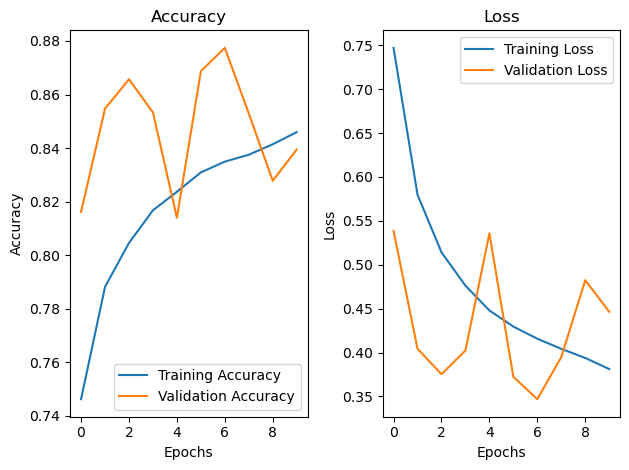

In [15]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



### 4.3 Evaluating Initial Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8706 - loss: 0.3537
Test Loss: 0.3524506688117981
Test Accuracy: 0.8731499910354614
Model evaluation time: 2.6288 seconds
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step
Inference time for predictions: 1.1585 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       976
           1       0.64      0.91      0.75      1023
           2       0.96      0.91      0.94      1003
           3       0.98      0.99      0.99      1035
           4       0.99      0.93      0.96       903
           5       0.94      0.93      0.94       928
           6       0.98      0.92      0.95       959
           7       0.97      1.00      0.98      1098
           8       0.99      0.88      0.93       941
           9       0.95      0.89      0.92       929
           A       0.93      0.99      0.96       170
           B       0.88      0.94      0.91       118
      

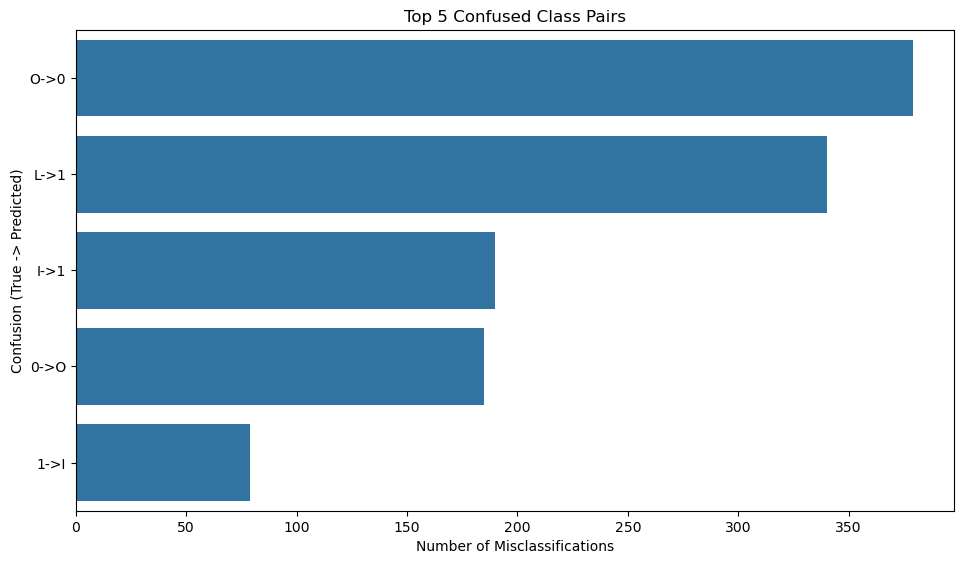




Visualizing misclassified examples for top confused pairs:


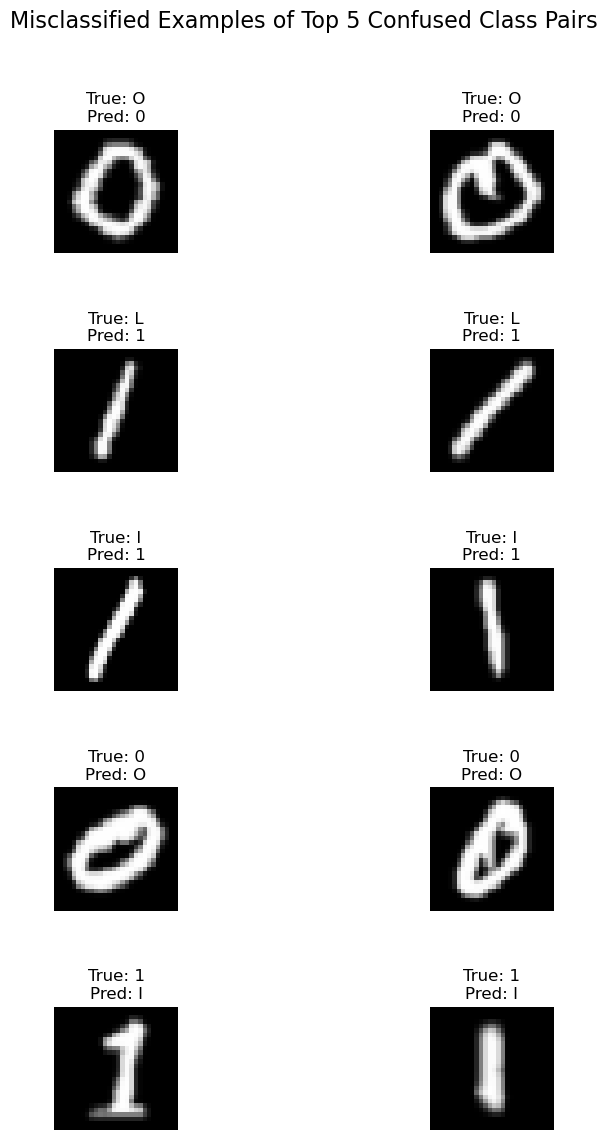




Plotting per-class accuracy (sorted):


/tmp/ipykernel_1841410/2503681307.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_accuracy, y=sorted_labels, palette='coolwarm')


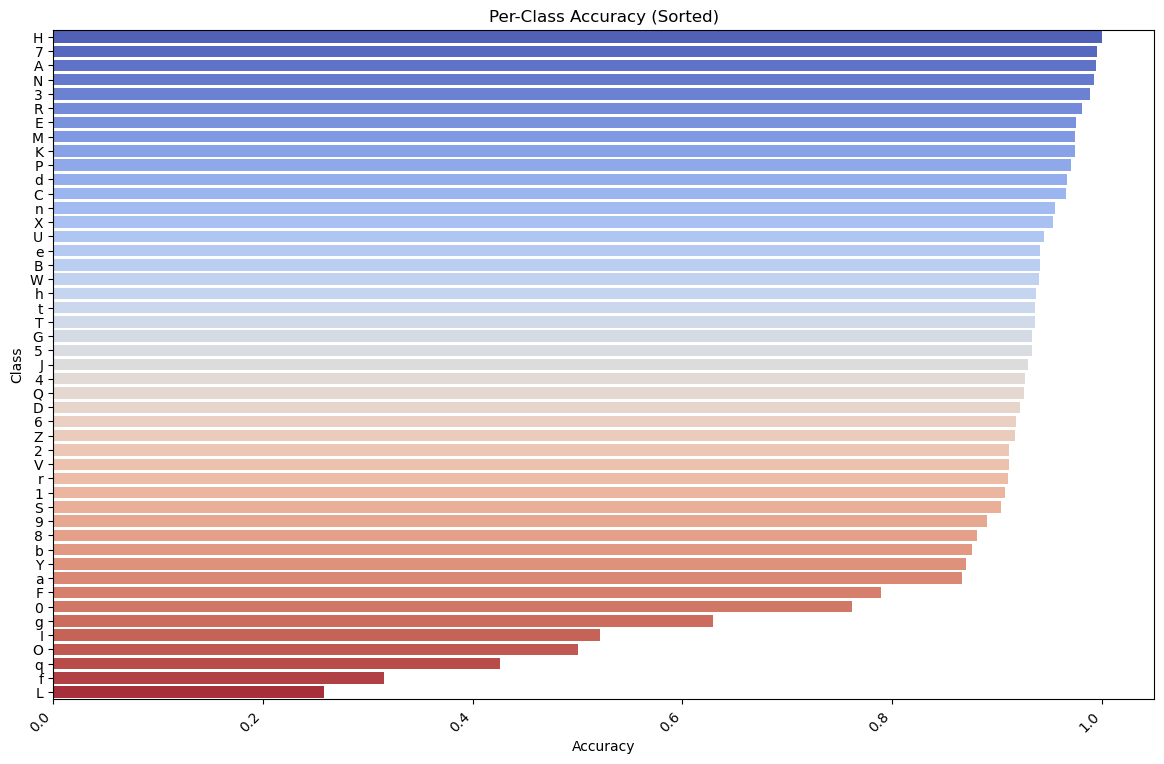

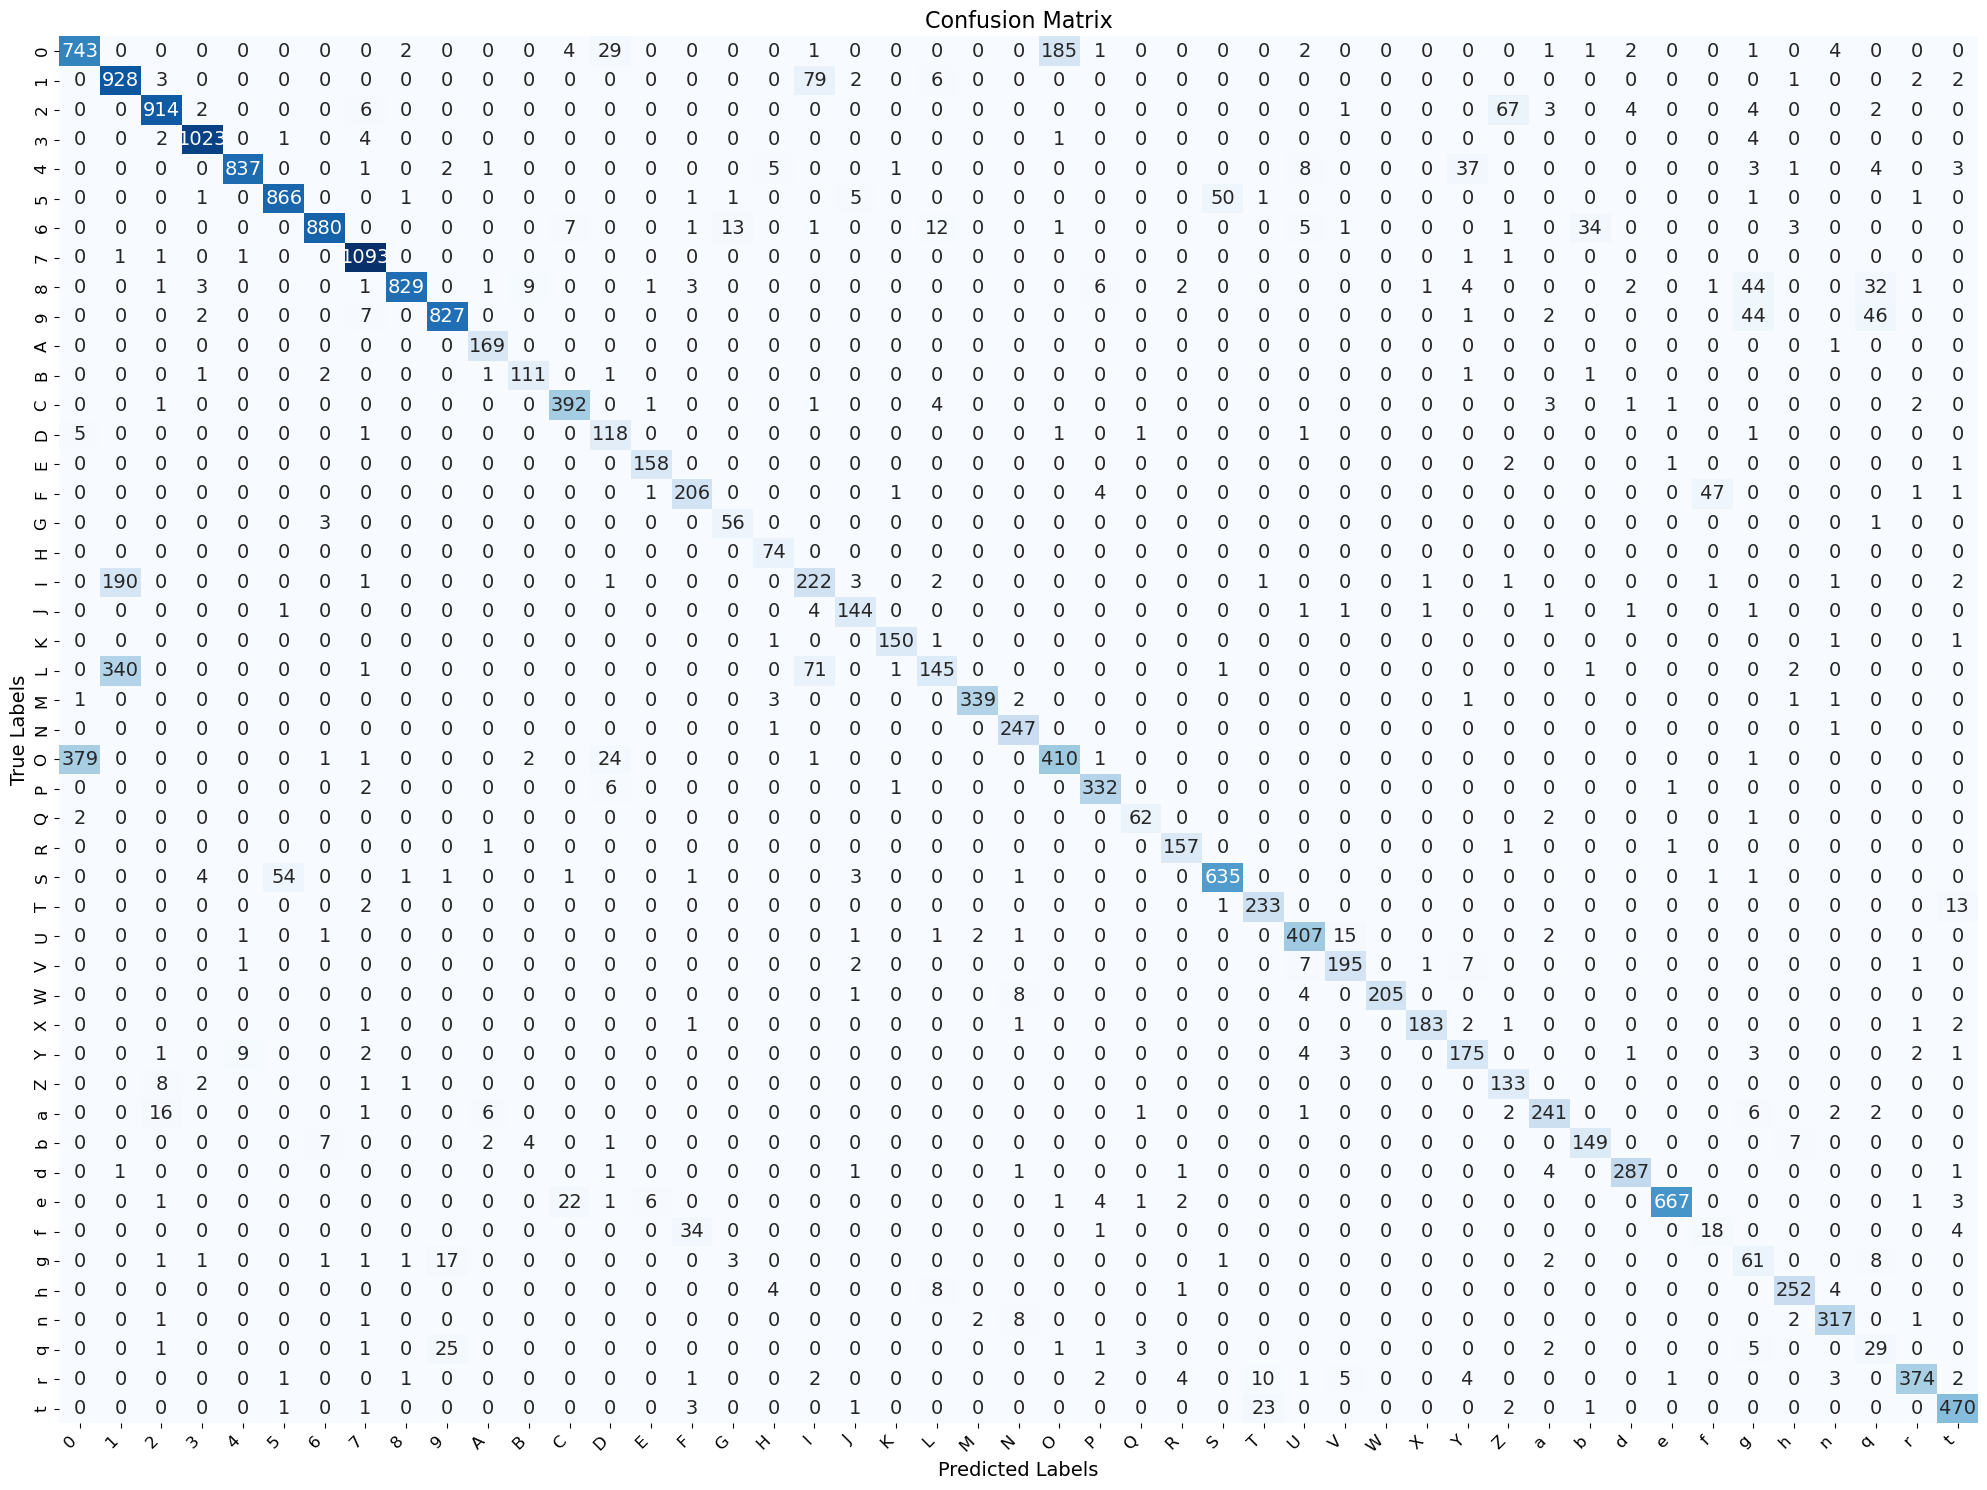

In [16]:
# Step 1: Evaluate model using test set
start_time = time.time()  # Start the timer for model evaluation
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=64)
end_time = time.time()  # End the timer
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Model evaluation time: {end_time - start_time:.4f} seconds")

# Step 2: Measuring inference time
start_time = time.time()  # Start the timer for prediction inference
predictions = model.predict(test_images)
end_time = time.time()  # End the timer
predicted_labels = np.argmax(predictions, axis=1)
print(f"Inference time for predictions: {end_time - start_time:.4f} seconds")

# Step 3: Generate a classification report using mapping
mapped_test_labels = [label_mapping[label] for label in test_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

print("\nClassification Report:")
print(classification_report(mapped_test_labels, mapped_predicted_labels, target_names=label_mapping))

# Step 4: Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)


# Step 5: Find the top 5 most confused class pairs

def create_plots(cm, label_mapping):

    confusion_pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j:
                confusion_pairs.append((i, j, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    top_5_confused = confusion_pairs[:5]

    # Step 6: Bar chart for top 5 confused pairs
    print("\nBar chart for the top 5 confused class pairs:")
    top_true_classes = [label_mapping[true_class] for true_class, _, _ in top_5_confused]
    top_pred_classes = [label_mapping[pred_class] for _, pred_class, _ in top_5_confused]
    top_confusion_counts = [count for _, _, count in top_5_confused]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_confusion_counts, y=[f"{true}->{pred}" for true, pred in zip(top_true_classes, top_pred_classes)], legend=False)
    plt.xlabel("Number of Misclassifications")
    plt.ylabel("Confusion (True -> Predicted)")
    plt.title("Top 5 Confused Class Pairs")
    plt.tight_layout(pad=2.0)  # Add spacing between charts
    plt.show()

    print("\n\n")  # Add space between plots

    # Step 7: Visualize misclassified examples for each pair
    print("Visualizing misclassified examples for top confused pairs:")
    num_examples = 2  # Number of examples to show for each confused pair
    fig, axes = plt.subplots(len(top_5_confused), num_examples, figsize=(10, 12))  # Adjusted figure size
    fig.suptitle("Misclassified Examples of Top 5 Confused Class Pairs", fontsize=16)

    for idx, (true_class, pred_class, count) in enumerate(top_5_confused):
        true_label = label_mapping[true_class]
        pred_label = label_mapping[pred_class]

        # Find examples of this confusion
        confused_indices = np.where((test_labels == true_class) & (predicted_labels == pred_class))[0]

        # Plot examples with rotation and flipping
        for example_idx in range(min(len(confused_indices), num_examples)):
            confused_example = test_images[confused_indices[example_idx]].reshape(28, 28)


            axes[idx, example_idx].imshow(confused_example, cmap='gray')
            axes[idx, example_idx].set_title(f"True: {true_label}\nPred: {pred_label}")
            axes[idx, example_idx].axis('off')

    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(top=0.88)
    plt.show()

    print("\n\n")  # Add space between plots

    # Step 8: Additional Evaluation - Sorted Per-Class Accuracy Plot
    # Calculate per-class accuracy
    print("Plotting per-class accuracy (sorted):")
    per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

    # Sort the per-class accuracy and corresponding labels
    sorted_indices = np.argsort(per_class_accuracy)[::-1]  # Sort in descending order
    sorted_accuracy = per_class_accuracy[sorted_indices]
    sorted_labels = [label_mapping[i] for i in sorted_indices]

    # Plot sorted per-class accuracy
    plt.figure(figsize=(12, 8))  # Larger figure for readability
    sns.barplot(x=sorted_accuracy, y=sorted_labels, palette='coolwarm')
    plt.xlabel('Accuracy')
    plt.ylabel('Class')
    plt.title('Per-Class Accuracy (Sorted)')

    # Rotate the class names for readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout(pad=2.0)
    plt.show()

create_plots(cm, label_mapping)

display_conf(cm)


All things considered, this initial model perfoms pretty decently on the unseen data. Look at the examples yourself and decide whether you would have honestly guessed the correct label

## 4.4 Setting up Hyperparameter Tuning

## Hyperparameters for CNN Model Tuning

CNN models have a wide range of hyperparameters that we can attempt to tune to optimize performance. Below is a breif description of the hyperparameters we have elected to tune, note that this is not the full exhaustive list due to the issue of computation time.

### 1. **Convolutional Layer Parameters**
- **Number of Convolution Layers:** the number of convolution layers in the network, more allows for richer feature extraction
- **Filters/Feature Maps:** List defining the number of filter in each layer, filter size increases however the options range from a large increase as well a a static number to capture more complex feautres
- **Kernel Size:** The size of the filter, which is a small square matrix
- **Strides:** This hyperparameter alters the strides for the convolution layer or the pooling layer, i.e the steps taken by the filter layers or pooling layers
- **Pooling Frequency**: Alters how often we add a pooling layer i.e after each convolution layer or not
- **Pool Size:** Size of the pooling window to alter the reduction in dimension of inputs

### 2. **Dense Layer Parameters**
- **Dense Layers**: This parameter alters the number of dense layers after our convolutional pooling blocks
- **Dense Neurons**: This controls the number of neurons in each of the aforementioned dense layers

### 3. **Dropout Parameters**
- **Dropout Rates**: Dropout rates attempt to mitigate overfitting, this set of parameters selects a set of 3 rates randomly and applys them to the dense layers for regularisation.

### 4. **Activation Functions**
   - **activation**: The activation function applied after each layer, relu or leaky relu will be tested.

### 5. **Input & Output**
   - **Input shape and Number of Classes:** This is static but added as a hyperparameter for consistency

### 6. **Optimizer and Learning Rate**
   - **Optimizesr**: Alters the optimisation algorithm used for backpropagation, Adam and rmsprop are tested.
   - **learning_rate**: Controls how quickly the model learns, different rates are tested to attempt to escape local minima.


### 7. **Loss Function**
   - **Loss funciton:** loss functin used it categorical cross entropy and will stay static due to nature of inputs.

Tuning these hyperparameters will allow us to find the best structure for achieving a high accuracy.

In [17]:
# https://github.com/keras-team/keras-tuner/issues/128
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your custom hypermodel class
class MyHyperModel(kt.HyperModel):
    def __init__(self):
        super().__init__()
        self.hp_log = []

    def build(self, hp):
        self.hp_log = []  # Reset the log for each build
        input_shape = (28, 28, 1)
        num_classes = 47

        model = keras.Sequential()
        model.add(keras.Input(shape=input_shape))

        filter_grids = [
            [32, 48, 64, 128], #Original
            [32, 64, 128, 256], #Vast Increase
            [64, 64, 64, 64], #Constant
            [128, 64, 32, 32], #Decreasing
        ]

        selected_grid_idx = self._log_hp(hp.Choice, 'filter_grid', [0, 1, 2, 3])
        filters = filter_grids[selected_grid_idx]

        conv_layers = self._log_hp(hp.Int, 'conv_layers', min_value=2, max_value=5, step=1)
        kernel_size_options = [(3, 3), (5, 5)]
        selected_kernel_size_idx = self._log_hp(hp.Choice, 'kernel_size', [0, 1])
        kernel_size = kernel_size_options[selected_kernel_size_idx]

        conv_strides_options = [(1, 1), (2, 2)]
        selected_conv_strides_idx = self._log_hp(hp.Choice, 'conv_strides', [0, 1])
        conv_strides = conv_strides_options[selected_conv_strides_idx]

        pool_size_options = [(2, 2), (3, 3)]
        selected_pool_size_idx = self._log_hp(hp.Choice, 'pool_size', [0, 1])
        pool_size = pool_size_options[selected_pool_size_idx]

        pool_strides_options = [None, (2, 2)]
        selected_pool_strides_idx = self._log_hp(hp.Choice, 'pool_strides', [0, 1])
        pool_strides = pool_strides_options[selected_pool_strides_idx]

        dense_layers = self._log_hp(hp.Int, 'dense_layers', min_value=1, max_value=3, step=1)
        dense_neurons = self._log_hp(hp.Choice, 'dense_neurons', [64, 128, 256])
        dropout_rate_1 = self._log_hp(hp.Choice, 'dropout_rate_1', [0.0, 0.3, 0.5])
        dropout_rate_2 = self._log_hp(hp.Choice, 'dropout_rate_2', [0.0, 0.2, 0.4])
        dropout_rate_3 = self._log_hp(hp.Choice, 'dropout_rate_3', [0.0, 0.1, 0.3])

        activation = self._log_hp(hp.Choice, 'activation', ['relu', 'leaky_relu'])
        pooling_frequency = self._log_hp(hp.Choice, 'pooling_frequency', [1, 2])

        optimizer_name = self._log_hp(hp.Choice, 'optimizer', ['adam', 'rmsprop'])
        learning_rate = self._log_hp(hp.Choice, 'learning_rate', [0.01, 0.001, 0.0001, 0.0005])

        for i in range(conv_layers):
            filter_num = filters[i] if i < len(filters) else filters[-1]
            model.add(layers.Conv2D(filter_num, kernel_size=kernel_size,
                                    strides=conv_strides, padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation(activation))

            # Get the current input shape before applying pooling
            current_shape = model.output_shape[1:3]  # Get height and width (ignores batch size and channels)
            if (i + 1) % pooling_frequency == 0 and current_shape[0] >= pool_size[0] and current_shape[1] >= pool_size[1]:
                model.add(layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides))

        model.add(layers.Flatten())

        dropout_rates = [dropout_rate_1, dropout_rate_2, dropout_rate_3]
        for i in range(dense_layers):
            model.add(layers.Dense(dense_neurons))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation(activation))
            if i < len(dropout_rates) and dropout_rates[i] > 0:
                model.add(layers.Dropout(dropout_rates[i]))

        model.add(layers.Dense(num_classes, activation="softmax"))

        # Compile the model
        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

    def _log_hp(self, hp_func, name, *args, **kwargs):
        value = hp_func(name, *args, **kwargs)
        self.hp_log.append({
            'name': name,
            'type': hp_func.__name__,
            'args': args,
            'kwargs': kwargs,
            'value': value
        })
        return value

    def fit(self, hp, model, *args, **kwargs):
        # Log the batch_size hyperparameter
        batch_size = self._log_hp(hp.Choice, "batch_size", [32, 64, 128])
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs,
        )

    def get_hp_log(self):
        return self.hp_log




Defining early stopping and setting up random search

In [18]:
import inspect
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


hypermodel = MyHyperModel()
tuner = kt.RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="kt_search_logs",
    project_name="cnn_hypermodel_tuning",
)

# Print the search space summary
print("Search space summary:")
tuner.search_space_summary(extended=True)

Search space summary:
Search space summary
Default search space size: 15
filter_grid (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
conv_strides (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
pool_size (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
pool_strides (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_neurons (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_rate_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3, 0.5], 'ordered': True}
dropout_rate_2 (Choice)
{'default'

## 4.5 Performing the search
Actually performing the search and obtaining the best model

In [19]:
import time



# Start the timer for hyperparameter search
start_time = time.time()

# Perform the hyperparameter search
tuner.search(
    train_datagen.flow(X_train, y_train),
    epochs=1, #CHANGE TO 1 maybe
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[early_stopping]
)


# End the timer for hyperparameter search
end_time = time.time()

# Calculate and print the time taken for the search
search_time = end_time - start_time
print(f"Time taken for hyperparameter search: {search_time:.4f} seconds")

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")



Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.670799970626831

Best val_accuracy So Far: 0.8550999760627747
Total elapsed time: 00h 08m 31s
Time taken for hyperparameter search: 511.2012 seconds
Best Hyperparameters: {'filter_grid': 1, 'conv_layers': 4, 'kernel_size': 1, 'conv_strides': 0, 'pool_size': 1, 'pool_strides': 1, 'dense_layers': 1, 'dense_neurons': 256, 'dropout_rate_1': 0.0, 'dropout_rate_2': 0.0, 'dropout_rate_3': 0.3, 'activation': 'relu', 'pooling_frequency': 2, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'batch_size': 128}


Displaying results of trails, and also building best model seperately to tuning process as asked for in the specifications

In [20]:
# Iterate through all trials and print details
for trial in tuner.oracle.trials.values():
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score: {trial.score}\n")

# Step 2: Build a new model with the best hyperparameters
current_model = tuner.hypermodel.build(best_hps)

# Step 4: Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Step 5: Start the timer for retraining
start_time = time.time()

# Step 6: Retrain the model with increased epochs
history = current_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=128),
    epochs=10,  #
    validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=best_hps.get('batch_size')),
    callbacks=[early_stopping]
)

# Step 7: End the timer and print the retraining time
end_time = time.time()
retrain_time = end_time - start_time
print(f"Time taken for retraining the best model: {retrain_time:.2f} seconds")

# Step 8: Save the retrained model
current_model.save('retrained_best_model.h5')
print("Retrained model saved as 'retrained_best_model.h5'.")


Trial ID: 00
Hyperparameters: {'filter_grid': 0, 'conv_layers': 3, 'kernel_size': 0, 'conv_strides': 0, 'pool_size': 0, 'pool_strides': 1, 'dense_layers': 2, 'dense_neurons': 256, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'dropout_rate_3': 0.1, 'activation': 'relu', 'pooling_frequency': 2, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'batch_size': 32}
Score: 0.8522999882698059

Trial ID: 01
Hyperparameters: {'filter_grid': 2, 'conv_layers': 3, 'kernel_size': 0, 'conv_strides': 0, 'pool_size': 0, 'pool_strides': 0, 'dense_layers': 3, 'dense_neurons': 256, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.0, 'dropout_rate_3': 0.0, 'activation': 'leaky_relu', 'pooling_frequency': 1, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64}
Score: 0.8306999802589417

Trial ID: 02
Hyperparameters: {'filter_grid': 3, 'conv_layers': 2, 'kernel_size': 1, 'conv_strides': 0, 'pool_size': 0, 'pool_strides': 1, 'dense_layers': 2, 'dense_neurons': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0

2024-10-14 21:37:55.598165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1145', 4 bytes spill stores, 4 bytes spill loads

2024-10-14 21:37:56.292326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1266', 80 bytes spill stores, 80 bytes spill loads

2024-10-14 21:37:56.410383: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1266', 312 bytes spill stores, 312 bytes spill loads

2024-10-14 21:37:56.783009: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 448 bytes spill stores, 448 bytes spill loads



704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.7276 - loss: 1.0447 - val_accuracy: 0.8710 - val_loss: 0.3904
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8678 - loss: 0.3979 - val_accuracy: 0.8461 - val_loss: 0.4798
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8825 - loss: 0.3322 - val_accuracy: 0.8557 - val_loss: 0.4140
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8905 - loss: 0.3062 - val_accuracy: 0.8789 - val_loss: 0.3389
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8940 - loss: 0.2917 - val_accuracy: 0.8838 - val_loss: 0.3170
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8978 - loss: 0.2761 - val_accuracy: 0.8818 - val_loss: 0.3210
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8989 - loss: 0.2705 - val_accuracy: 0.8873 - val_loss: 0.3020
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8999 - loss: 0.2622 - val_accurac

Time taken for retraining the best model: 172.27 seconds
Retrained model saved as 'retrained_best_model.h5'.


Evaluation of the best perfoming model using

* Test Loss/ Accuracy / Model Eval Time
* Inference Time
* Classification Report Providing Accuracy/Precision/Recall
* Confusion Pairs
* Contrasting Performance of differing hyperparameters using a multitude of plots
* Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8896 - loss: 0.2934
Test Loss: 0.29614412784576416
Test Accuracy: 0.8903999924659729
Model evaluation time: 0.9551 seconds
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step
Inference time for predictions: 1.1517 seconds




Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.94      0.73       976
           1       0.67      0.89      0.76      1023
           2       0.97      0.94      0.96      1003
           3       1.00      0.99      0.99      1035
           4       0.96      0.98      0.97       903
           5       0.93      0.95      0.94       928
           6       0.97      0.97      0.97       959
           7       0.99      0.99      0.99      1098
           8       0.99      0.95      0.97       941
           9       0.90      0.99      0.94       929
           A       0.95      0.95      0.95       170
           B       0.90      0.98      0.94       118
  

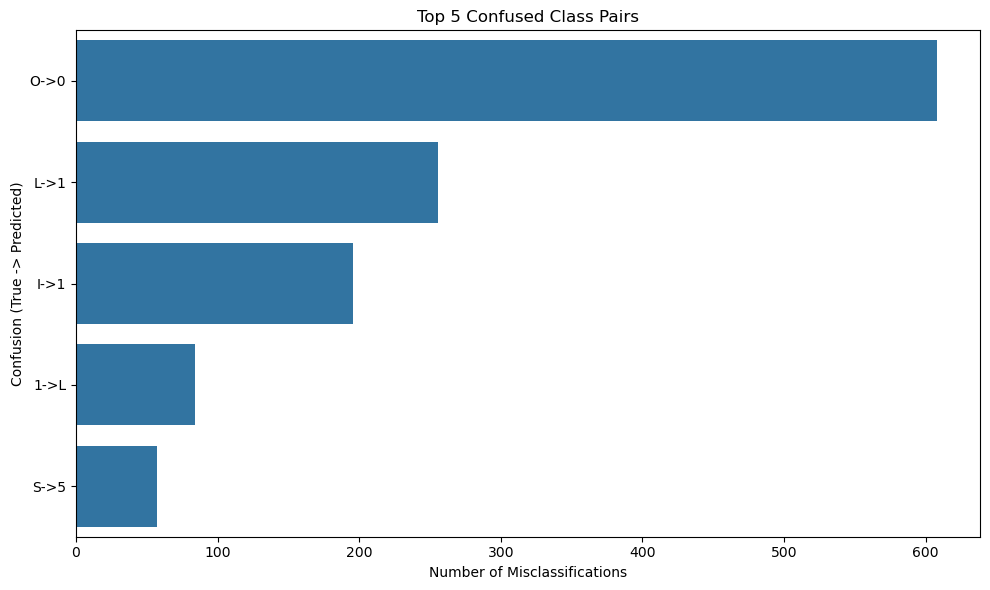




Visualizing misclassified examples for top confused pairs:


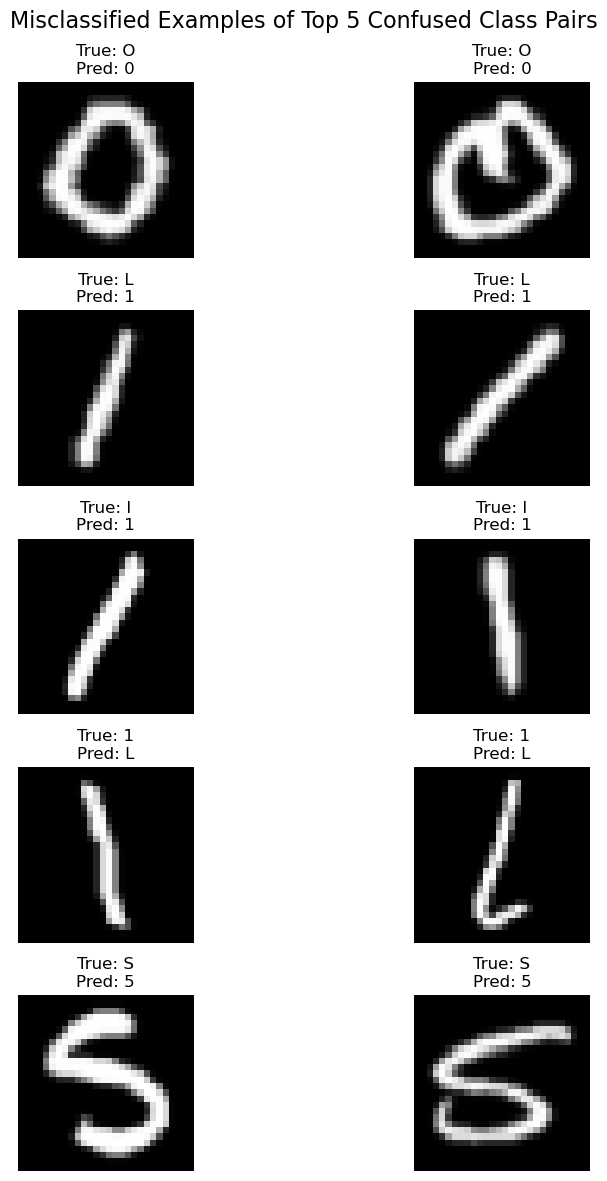




Plotting per-class accuracy (sorted):


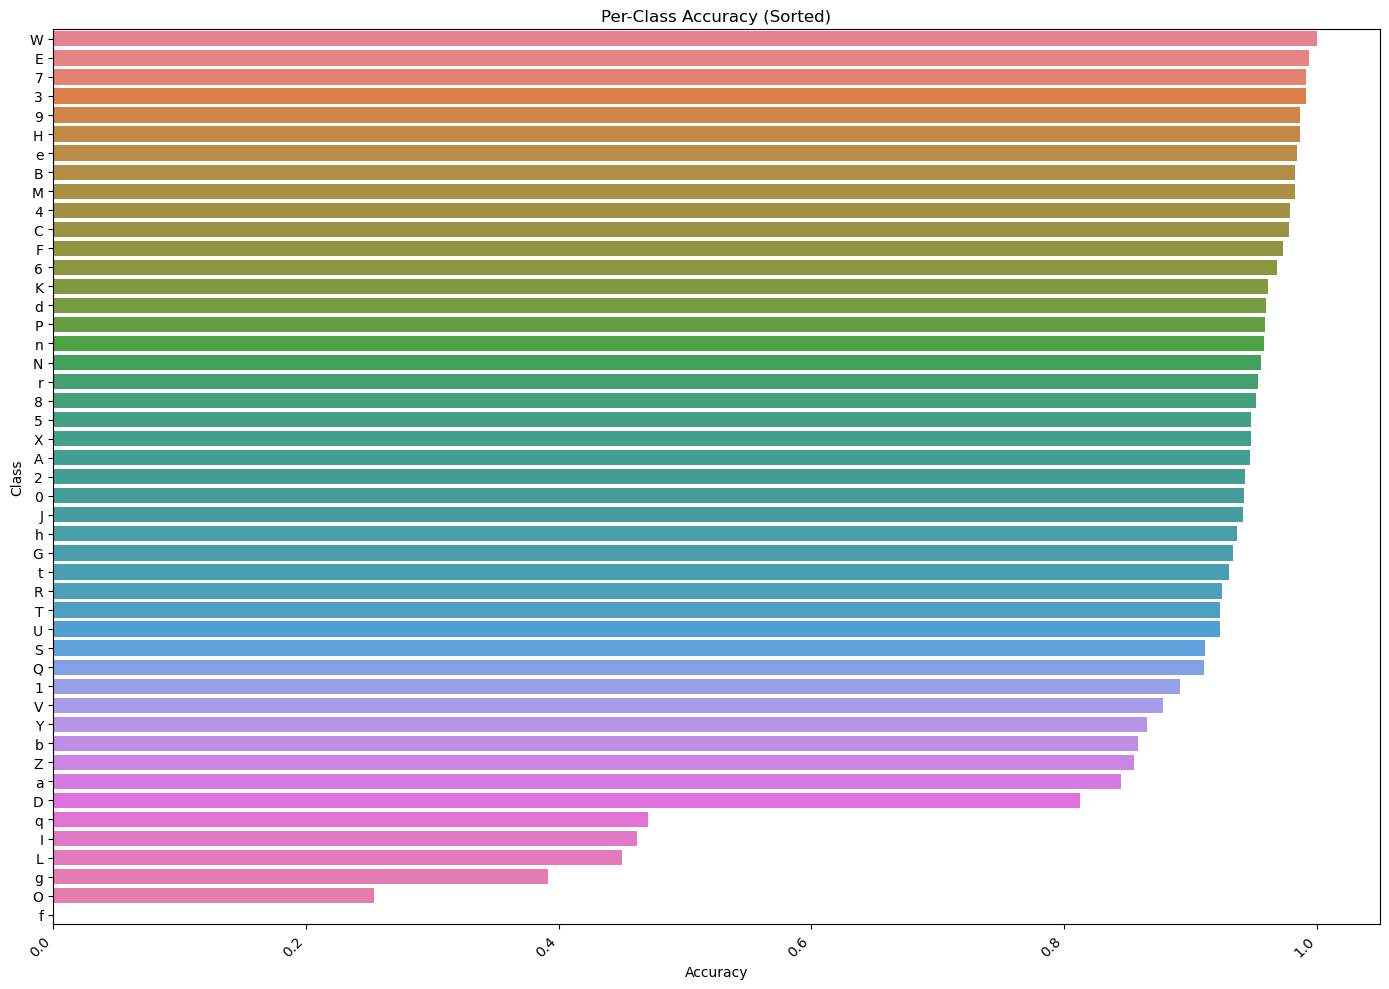

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Evaluate the best model on the test set again for sake of keeping all evaluations together
start_time = time.time()
test_loss, test_accuracy = current_model.evaluate(test_images, test_labels, batch_size=best_hps.get('batch_size'))
end_time = time.time()
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Model evaluation time: {end_time - start_time:.4f} seconds")

# Step 2: Measure inference time for predictions
start_time = time.time()
predictions = current_model.predict(test_images)
end_time = time.time()
predicted_labels = np.argmax(predictions, axis=1)
print(f"Inference time for predictions: {end_time - start_time:.4f} seconds")

# Add whitespace between sections for better readability
print("\n\n")

# Step 3: Generate a classification report using the mapped labels
mapped_test_labels = [label_mapping[label] for label in test_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# Use zero_division=0 to handle undefined precision/recall for classes with no predicted samples
print("\nClassification Report:")
print(classification_report(mapped_test_labels, mapped_predicted_labels, target_names=label_mapping, zero_division=0))

# Add whitespace before plotting confusion matrix
print("\n\n")

# Step 4: Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Step 5: Find the top 5 most confused class pairs
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
top_5_confused = confusion_pairs[:5]

# Step 6: Bar chart for top 5 confused pairs
print("\nBar chart for the top 5 confused class pairs:")
top_true_classes = [label_mapping[true_class] for true_class, _, _ in top_5_confused]
top_pred_classes = [label_mapping[pred_class] for _, pred_class, _ in top_5_confused]
top_confusion_counts = [count for _, _, count in top_5_confused]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_confusion_counts, y=[f"{true}->{pred}" for true, pred in zip(top_true_classes, top_pred_classes)])
plt.xlabel("Number of Misclassifications")
plt.ylabel("Confusion (True -> Predicted)")
plt.title("Top 5 Confused Class Pairs")
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace after the bar plot

# Step 7: Visualize misclassified examples for each pair
print("Visualizing misclassified examples for top confused pairs:")
num_examples = 2
fig, axes = plt.subplots(len(top_5_confused), num_examples, figsize=(10, 12))
fig.suptitle("Misclassified Examples of Top 5 Confused Class Pairs", fontsize=16)

for idx, (true_class, pred_class, count) in enumerate(top_5_confused):
    true_label = label_mapping[true_class]
    pred_label = label_mapping[pred_class]

    confused_indices = np.where((test_labels == true_class) & (predicted_labels == pred_class))[0]

    for example_idx in range(min(len(confused_indices), num_examples)):
        confused_example = test_images[confused_indices[example_idx]].reshape(28, 28)

        axes[idx, example_idx].imshow(confused_example, cmap='gray')
        axes[idx, example_idx].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[idx, example_idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Step 8: Per-Class Accuracy Plot (Sorted and Fixed)
print("Plotting per-class accuracy (sorted):")
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

sorted_indices = np.argsort(per_class_accuracy)[::-1]
sorted_accuracy = per_class_accuracy[sorted_indices]
sorted_labels = [label_mapping[i] for i in sorted_indices]

plt.figure(figsize=(14, 10))  # Larger figure to avoid cramping
sns.barplot(x=sorted_accuracy, y=sorted_labels, hue=sorted_labels, legend=False)
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Per-Class Accuracy (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


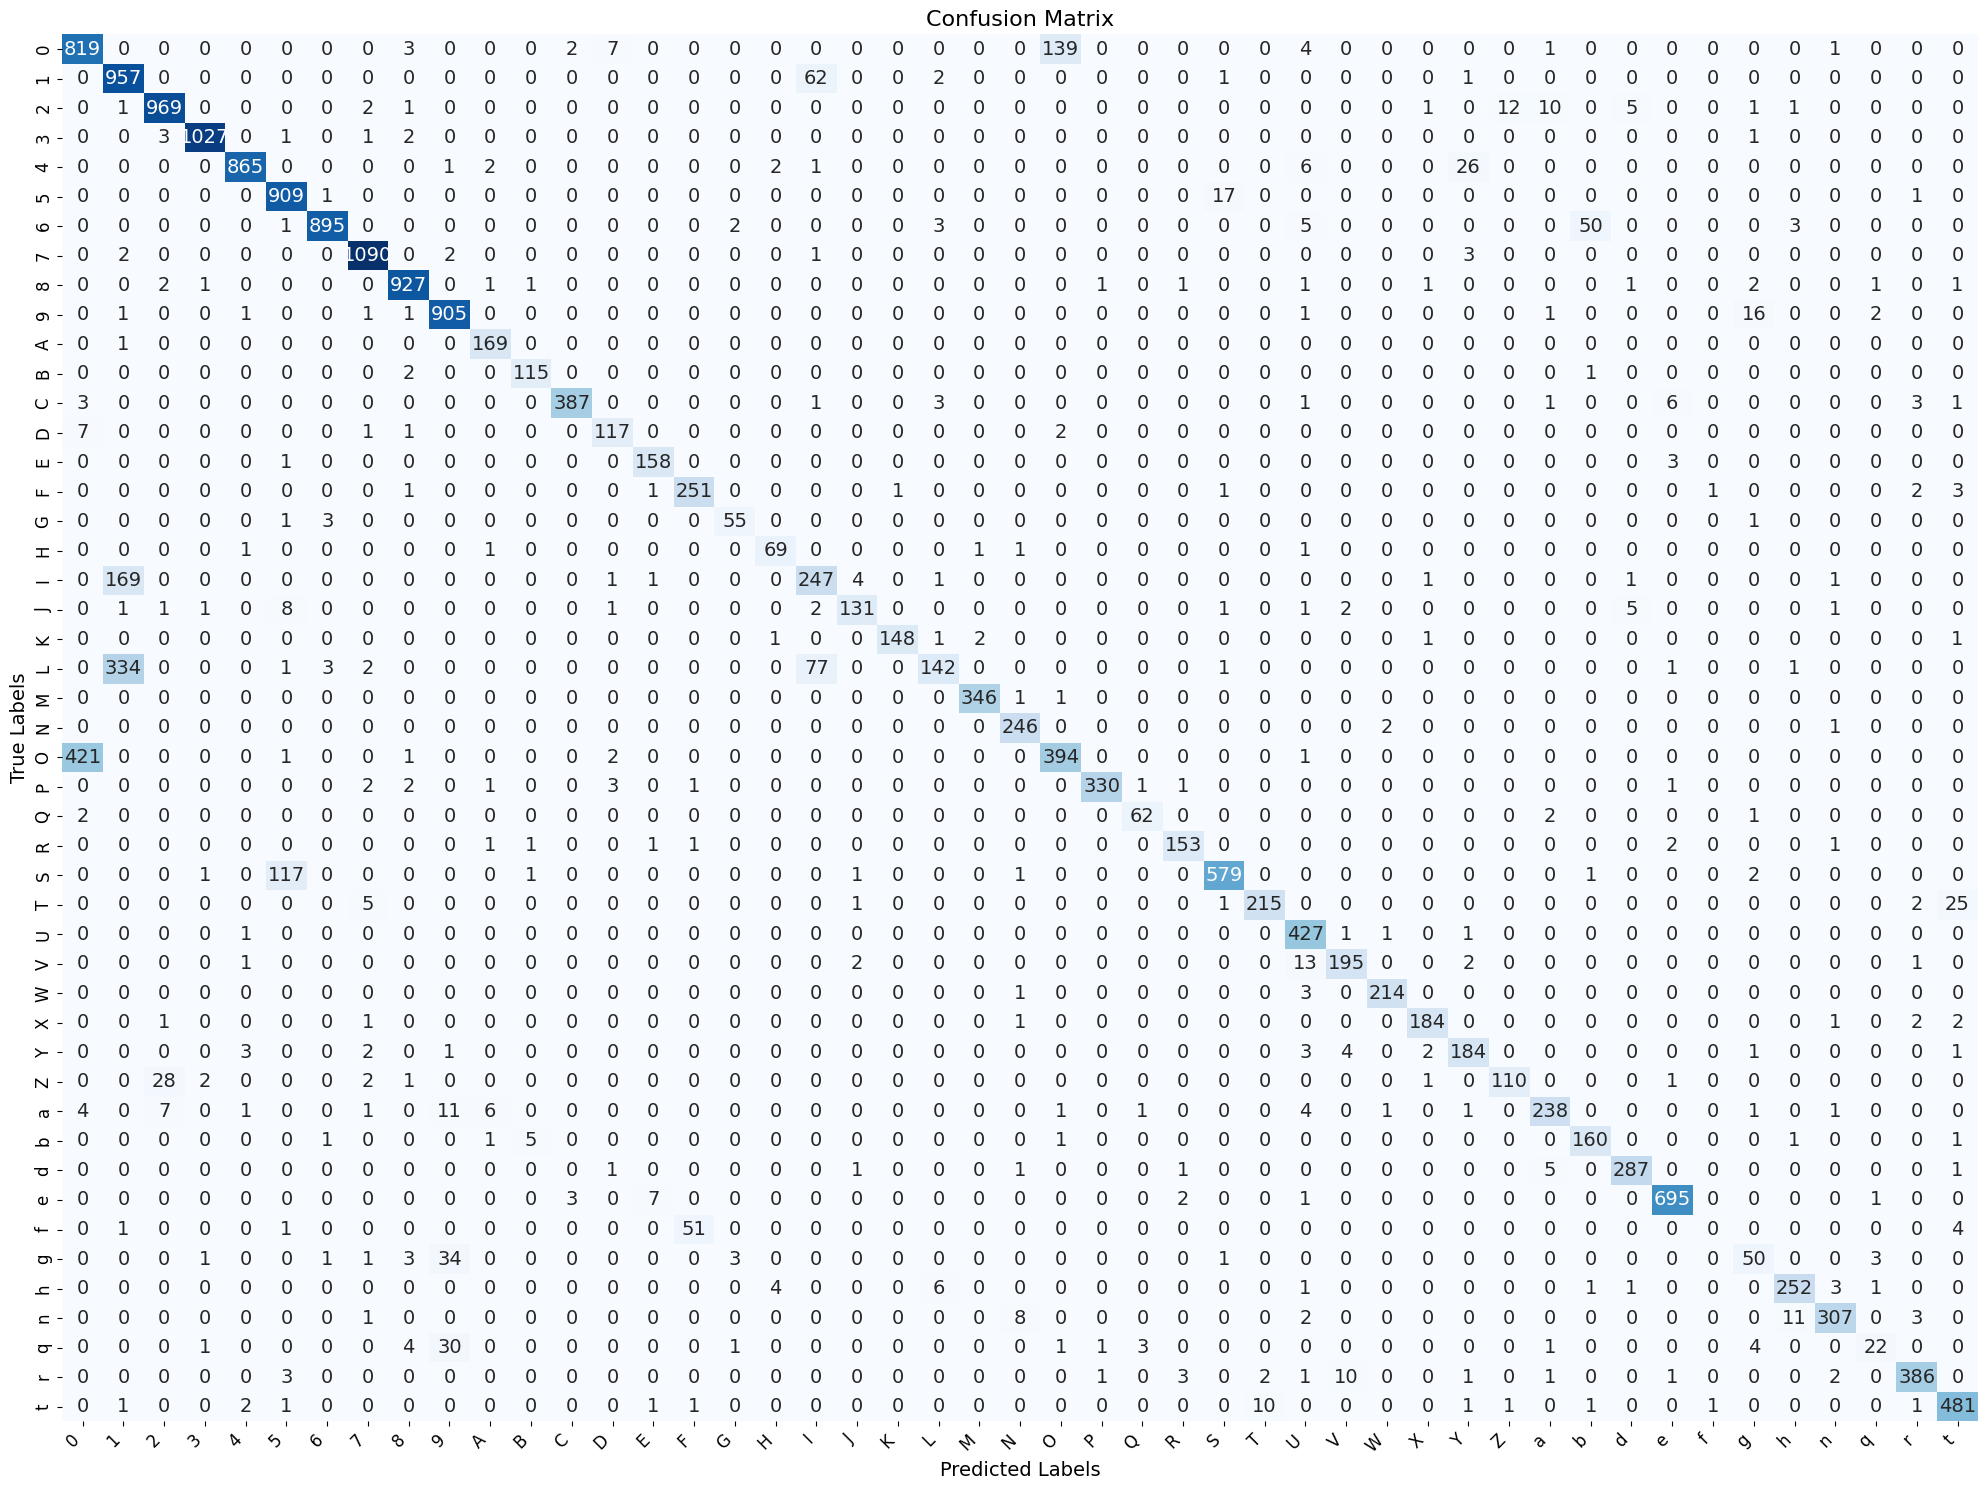

In [ ]:
#Conf Matrix Seperate Block for structure and readability
display_conf(cm)

#4.5 Hyperparameter Exploration


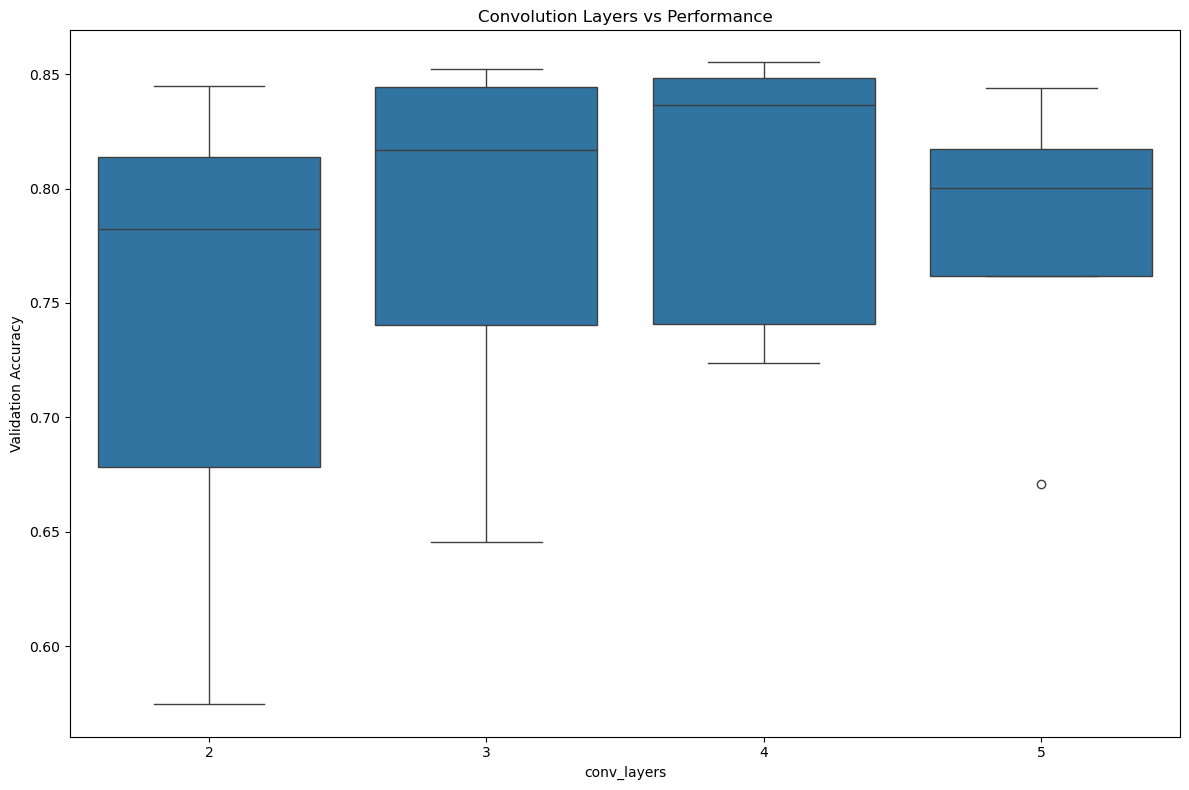




Dot plot for number of dense neurons vs dropout rates:


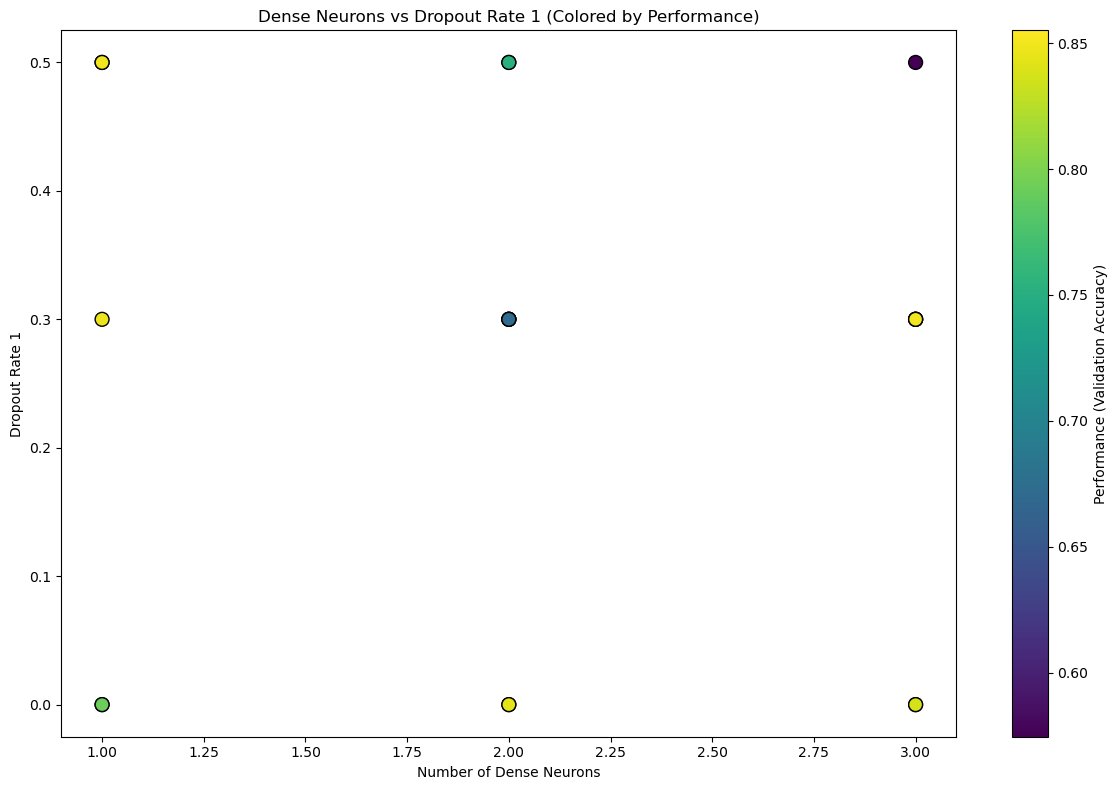




Analyzing interaction between filter grid type and conv_layers:


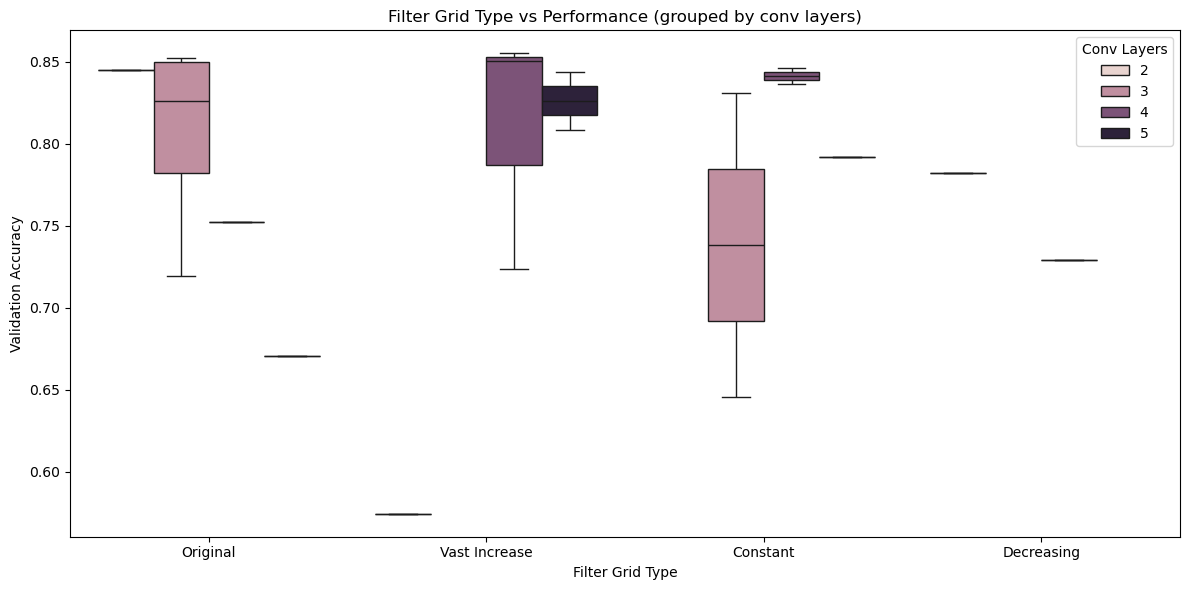

In [22]:
# Step q: Hyperparameter Performance Distribution
important_hps = [
    'filter_grid',
    'conv_layers',
    'kernel_size',
    'conv_strides',
    'pool_size',
    'pool_strides',
    'dense_layers',
    'dense_neurons',
    'dropout_rate_1',
    'dropout_rate_2',
    'dropout_rate_3',
    'activation',
    'pooling_frequency',
    'optimizer',
    'learning_rate'
]

# Initialize hp_data with all hyperparameters
hp_data = {hp: [] for hp in important_hps}
performances = []

for trial in tuner.oracle.trials.values():
    if trial.score is not None:
        for hp in important_hps:
            hp_data[hp].append(trial.hyperparameters.values[hp])
        performances.append(trial.score)



filter_grid_mapping = {
    0: 'Original',
    1: 'Vast Increase',
    2: 'Constant',
    3: 'Decreasing'
}

# Replace numeric filter_grid values with their descriptions in hp_data
for i, fg in enumerate(hp_data['filter_grid']):
    hp_data['filter_grid'][i] = filter_grid_mapping.get(fg, 'Unknown')

#Select 1 HP
selected_hp = 'conv_layers'

# Plot hyperparameter vs performance
plt.figure(figsize=(12, 8))
sns.boxplot(x=hp_data[selected_hp], y=performances)
plt.xlabel(selected_hp)
plt.ylabel('Validation Accuracy')
plt.title(f'Convolution Layers vs Performance')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Dot Plot
print("Dot plot for number of dense neurons vs dropout rates:")
plt.figure(figsize=(12, 8))

# Create a dot plot for 'dense_neurons' vs 'dropout_rate_1'
plt.scatter(hp_data['dense_layers'], hp_data['dropout_rate_1'], c=performances, cmap='viridis', edgecolor='k', s=100)

plt.xlabel('Number of Dense Neurons')
plt.ylabel('Dropout Rate 1')
plt.title('Dense Neurons vs Dropout Rate 1 (Colored by Performance)')
plt.colorbar(label='Performance (Validation Accuracy)')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace before the next plot

filter_order = ['Original', 'Vast Increase', 'Constant', 'Decreasing']
hp_data['filter_grid'] = pd.Categorical(hp_data['filter_grid'], categories=filter_order, ordered=True)

# Filter Grid vs Conv Layers
print("Analyzing interaction between filter grid type and conv_layers:")
plt.figure(figsize=(12, 6))

sns.boxplot(x=hp_data['filter_grid'], y=performances, hue=hp_data['conv_layers'])
plt.xlabel('Filter Grid Type')
plt.ylabel('Validation Accuracy')
plt.title('Filter Grid Type vs Performance (grouped by conv layers)')
plt.legend(title='Conv Layers')
plt.tight_layout()
plt.show()


Exploring Even More

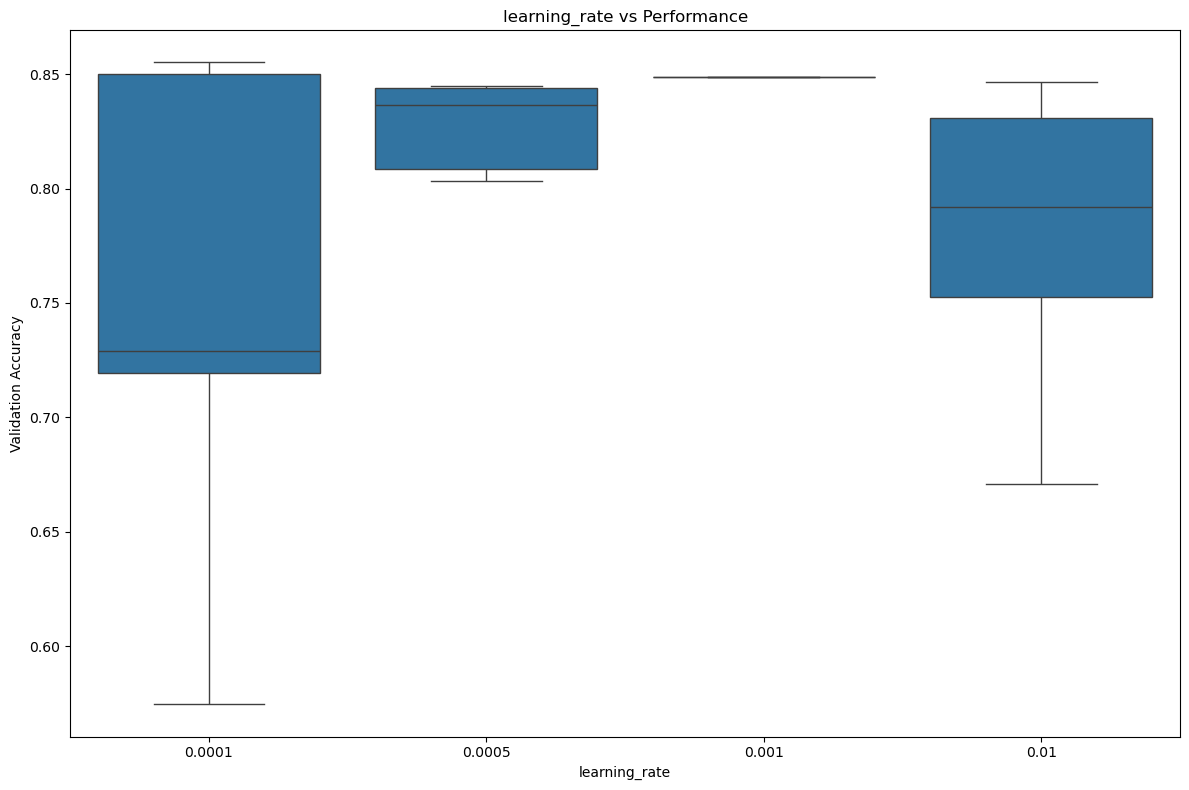

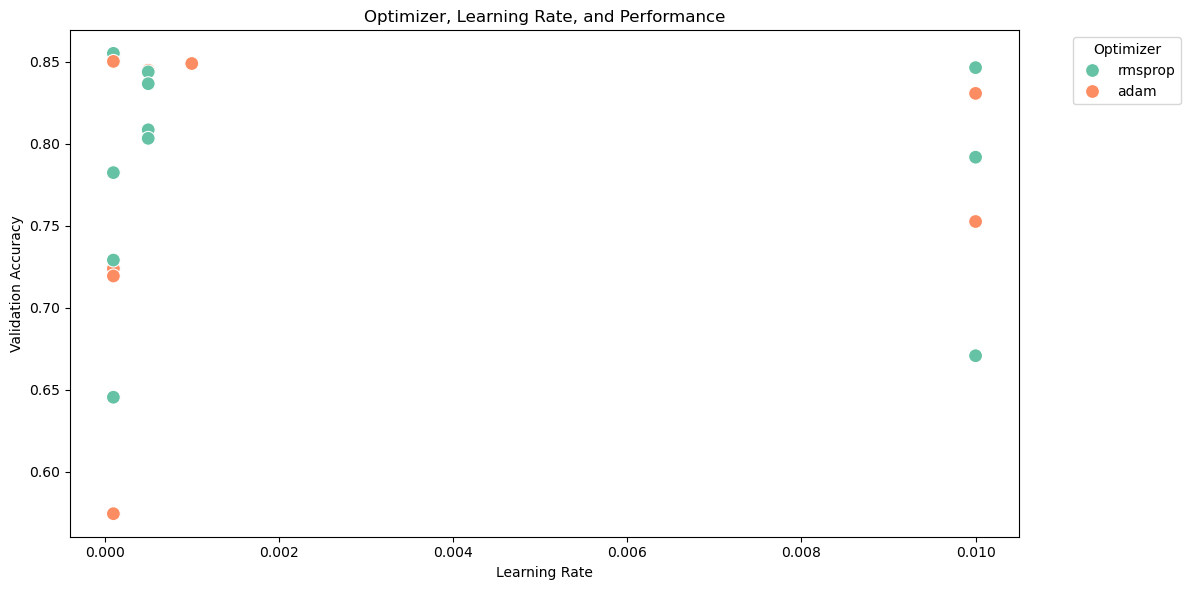

In [24]:
# Learning Rate vs Performance
selected_hp = 'learning_rate'

# Plot hyperparameter vs performance
plt.figure(figsize=(12, 8))
sns.boxplot(x=hp_data[selected_hp], y=performances)
plt.xlabel(selected_hp)
plt.ylabel('Validation Accuracy')
plt.title(f'{selected_hp} vs Performance')
plt.tight_layout()
plt.show()

print("\n\n")
# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=hp_data,
    x=hp_data['learning_rate'],  # Continuous variable on x-axis
    y=performances,    # Performance on y-axis
    hue=hp_data['optimizer'],    # Group by optimizer
    palette='Set2',
    s=100  # Set marker size
)

# Adding labels and title
plt.title('Optimizer, Learning Rate, and Performance')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

plt.legend(title='Optimizer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Final Importance Overview



In [25]:
# If available, print hyperparameter importance summary from Tuner
if hasattr(tuner, 'results_summary'):
    print("\nHyperparameter Importance:")
    tuner.results_summary()


Hyperparameter Importance:
Results summary
Results in kt_search_logs/cnn_hypermodel_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
filter_grid: 1
conv_layers: 4
kernel_size: 1
conv_strides: 0
pool_size: 1
pool_strides: 1
dense_layers: 1
dense_neurons: 256
dropout_rate_1: 0.0
dropout_rate_2: 0.0
dropout_rate_3: 0.3
activation: relu
pooling_frequency: 2
optimizer: rmsprop
learning_rate: 0.0001
batch_size: 128
Score: 0.8550999760627747

Trial 00 summary
Hyperparameters:
filter_grid: 0
conv_layers: 3
kernel_size: 0
conv_strides: 0
pool_size: 0
pool_strides: 1
dense_layers: 2
dense_neurons: 256
dropout_rate_1: 0.3
dropout_rate_2: 0.2
dropout_rate_3: 0.1
activation: relu
pooling_frequency: 2
optimizer: rmsprop
learning_rate: 0.0001
batch_size: 32
Score: 0.8522999882698059

Trial 10 summary
Hyperparameters:
filter_grid: 1
conv_layers: 4
kernel_size: 0
conv_strides: 0
pool_size: 1
pool_strides: 0
dense_layers: 3
dense_neurons: 

In [1]:
!pip install torch
!pip install torchvision
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

        # resize and convert to 3 channels
        self.transform = transforms.Compose([
            transforms.ToPILImage(),                    # Convert tensor to PIL Image
            transforms.Resize(224),                     # Resize image to 224x224 pixels
            transforms.Grayscale(num_output_channels=3),# Convert to 3 channels by duplicating the grayscale channel
            transforms.ToTensor()                       # Convert back to tensor
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return self.transform(image), label

# # Create datasets with transforms
train_dataset = CustomDataset(X_train, y_train)
valid_dataset = CustomDataset(X_valid, y_valid)
test_dataset = CustomDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
from torchvision.models import resnet18
import torch.nn as nn

num_classes = len(np.unique(train_labels))
resnet = resnet18(num_classes, pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
print(resnet)

/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/calvin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
from torchvision.models.vision_transformer import vit_b_16

vit = vit_b_16(pretrained=False)
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=num_classes)
)

print(vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def display_conf(conf_matrix):
    # Get the number of classes
    num_classes = conf_matrix.shape[0]

    # Create character labels using the label_mapping
    char_labels = [label_mapping[i] for i in range(num_classes)]

    plt.figure(figsize=(20, 15))  # Increase the size of the figure for readability
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=char_labels, yticklabels=char_labels,
                cbar=False, annot_kws={"size": 14})
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Labels', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent cutting off labels
    plt.show()

def train_model(
    model,
    train_loader,
    valid_loader,
    test_loader,
    train_labels,
    class_weights_dict,
    num_epochs=10,
    learning_rate=0.0001,
    optimizer_name='Adam',
    momentum=0.9,
    weight_decay=0.0,
    scheduler_name=None,
    step_size=5,
    gamma=0.1,
    patience=2
):
    # Set device (GPU if available)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Prepare class weights
    classes = np.unique(train_labels)
    class_weights_list = [class_weights_dict[cls] for cls in classes]
    class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)

    # Define loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Define learning rate scheduler if provided
    if scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=gamma)
    else:
        scheduler = None  # No scheduler by default
    train_time = 0
    # Training Loop with Progress Bar
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_epoch = time.time()
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update metrics
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.update(1)
                pbar.set_postfix(loss=running_loss / total, accuracy=100.0 * correct / total)
        end_epoch = time.time()
        train_time += end_epoch - start_epoch
        # Validation Loop (Calculate Validation Accuracy after Each Epoch)
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {val_accuracy:.2f}%')

        # Step the scheduler if available
        if scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(running_loss / total)  # Step with validation loss
        elif scheduler:
            scheduler.step()

        model.train()

    # Evaluate the model on the test data and generate predictions
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=[str(cls) for cls in classes], zero_division=0)
    print("\nClassification Report:\n", report)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return {
        'classification_report': report,
        'confusion_matrix': conf_matrix,
        'validation_accuracy': val_accuracy
    }

In [ ]:
# Function to generate all combinations of hyperparameters
def generate_hyperparam_combinations(param_grid):
    keys, values = zip(*param_grid.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

# Function to run hyperparameter tuning and return the best configuration based on validation accuracy
def run_hyperparameter_tuning(model, param_grid, train_loader, test_loader, train_labels, class_weights_dict, max_runs=10):
    # Generate all combinations of hyperparameters
    hyperparam_combinations = generate_hyperparam_combinations(param_grid)

    # Limit the number of runs to max_runs
    if len(hyperparam_combinations) > max_runs:
        hyperparam_combinations = hyperparam_combinations[:max_runs]

    # Initialize variables to store the best configuration and best validation accuracy
    best_config = None
    best_val_accuracy = -1  # Start with the lowest possible accuracy
    results = []

    # Run training for each combination of hyperparameters
    for i, params in enumerate(hyperparam_combinations):
        print(f"\nRunning hyperparameter tuning run {i+1}/{len(hyperparam_combinations)}")
        print(f"Hyperparameters: {params}")

        # Train the model with the current hyperparameters
        result = train_model(
            model=model,  # Pass the initialized model instance
            train_loader=train_loader,
            test_loader=test_loader,
            train_labels=train_labels,
            class_weights_dict=class_weights_dict,
            num_epochs=2,
            learning_rate=params['learning_rate'],
            optimizer_name=params['optimizer_name'],
            momentum=params.get('momentum', 0.9),
            weight_decay=params['weight_decay'],
            scheduler_name=params['scheduler_name'],
            step_size=params.get('step_size', 5),
            gamma=params.get('gamma', 0.1),
            patience=params.get('patience', 2)
        )

        # Get validation accuracy from the result
        val_accuracy = result['validation_accuracy']
        results.append({'params': params, 'validation_accuracy': val_accuracy})

        # Check if this configuration is the best
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_config = params

        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # After all runs, sort the results by validation accuracy
    results.sort(key=lambda x: x['validation_accuracy'], reverse=True)

    # Print the top configurations
    print("\nTop configurations by validation accuracy:")
    for rank, result in enumerate(results[:5], 1):  # Show top 5
        print(f"Rank {rank}: {result['params']} - Validation Accuracy: {result['validation_accuracy']:.2f}%")

    # Return the best configuration
    return best_config, best_val_accuracy


In [ ]:
resnet_results = train_model(model=resnet, train_loader=train_loader, test_loader=test_loader, train_labels=train_labels, class_weights_dict=class_weights_dict, num_epochs=10, learning_rate=5e-5)

Epoch [1/10]:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch [1/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.48batch/s, accuracy=84.1, loss=0.54] 


Epoch [1/10] Validation Accuracy: 86.75%


Epoch [2/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.48batch/s, accuracy=88.2, loss=0.288]


Epoch [2/10] Validation Accuracy: 89.35%


Epoch [3/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.51batch/s, accuracy=89.1, loss=0.245]


Epoch [3/10] Validation Accuracy: 89.39%


Epoch [4/10]: 100%|██████████| 3125/3125 [01:54<00:00, 27.36batch/s, accuracy=90, loss=0.213]  


Epoch [4/10] Validation Accuracy: 89.09%


Epoch [5/10]: 100%|██████████| 3125/3125 [01:54<00:00, 27.23batch/s, accuracy=90.7, loss=0.187]


Epoch [5/10] Validation Accuracy: 87.99%


Epoch [6/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.49batch/s, accuracy=91.4, loss=0.161]


Epoch [6/10] Validation Accuracy: 87.27%


Epoch [7/10]: 100%|██████████| 3125/3125 [01:54<00:00, 27.35batch/s, accuracy=91.9, loss=0.145]


Epoch [7/10] Validation Accuracy: 89.20%


Epoch [8/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.55batch/s, accuracy=92.8, loss=0.123]


Epoch [8/10] Validation Accuracy: 89.80%


Epoch [9/10]: 100%|██████████| 3125/3125 [01:55<00:00, 27.16batch/s, accuracy=93.3, loss=0.108]


Epoch [9/10] Validation Accuracy: 89.12%


Epoch [10/10]: 100%|██████████| 3125/3125 [01:53<00:00, 27.42batch/s, accuracy=93.8, loss=0.0972]


Epoch [10/10] Validation Accuracy: 90.08%

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.75      0.73       976
           1       0.69      0.89      0.78      1023
           2       0.96      0.96      0.96      1003
           3       1.00      0.99      0.99      1035
           4       0.98      0.98      0.98       903
           5       0.94      0.95      0.95       928
           6       0.97      0.99      0.98       959
           7       0.99      0.98      0.99      1098
           8       0.99      0.98      0.98       941
           9       0.95      0.88      0.91       929
          10       0.94      0.95      0.94       170
          11       0.94      0.98      0.96       118
          12       0.97      0.98      0.97       406
          13       0.87      0.94      0.90       128
          14       0.93      0.99      0.96       162
          15       0.87      0.90      0.89       261
          16  

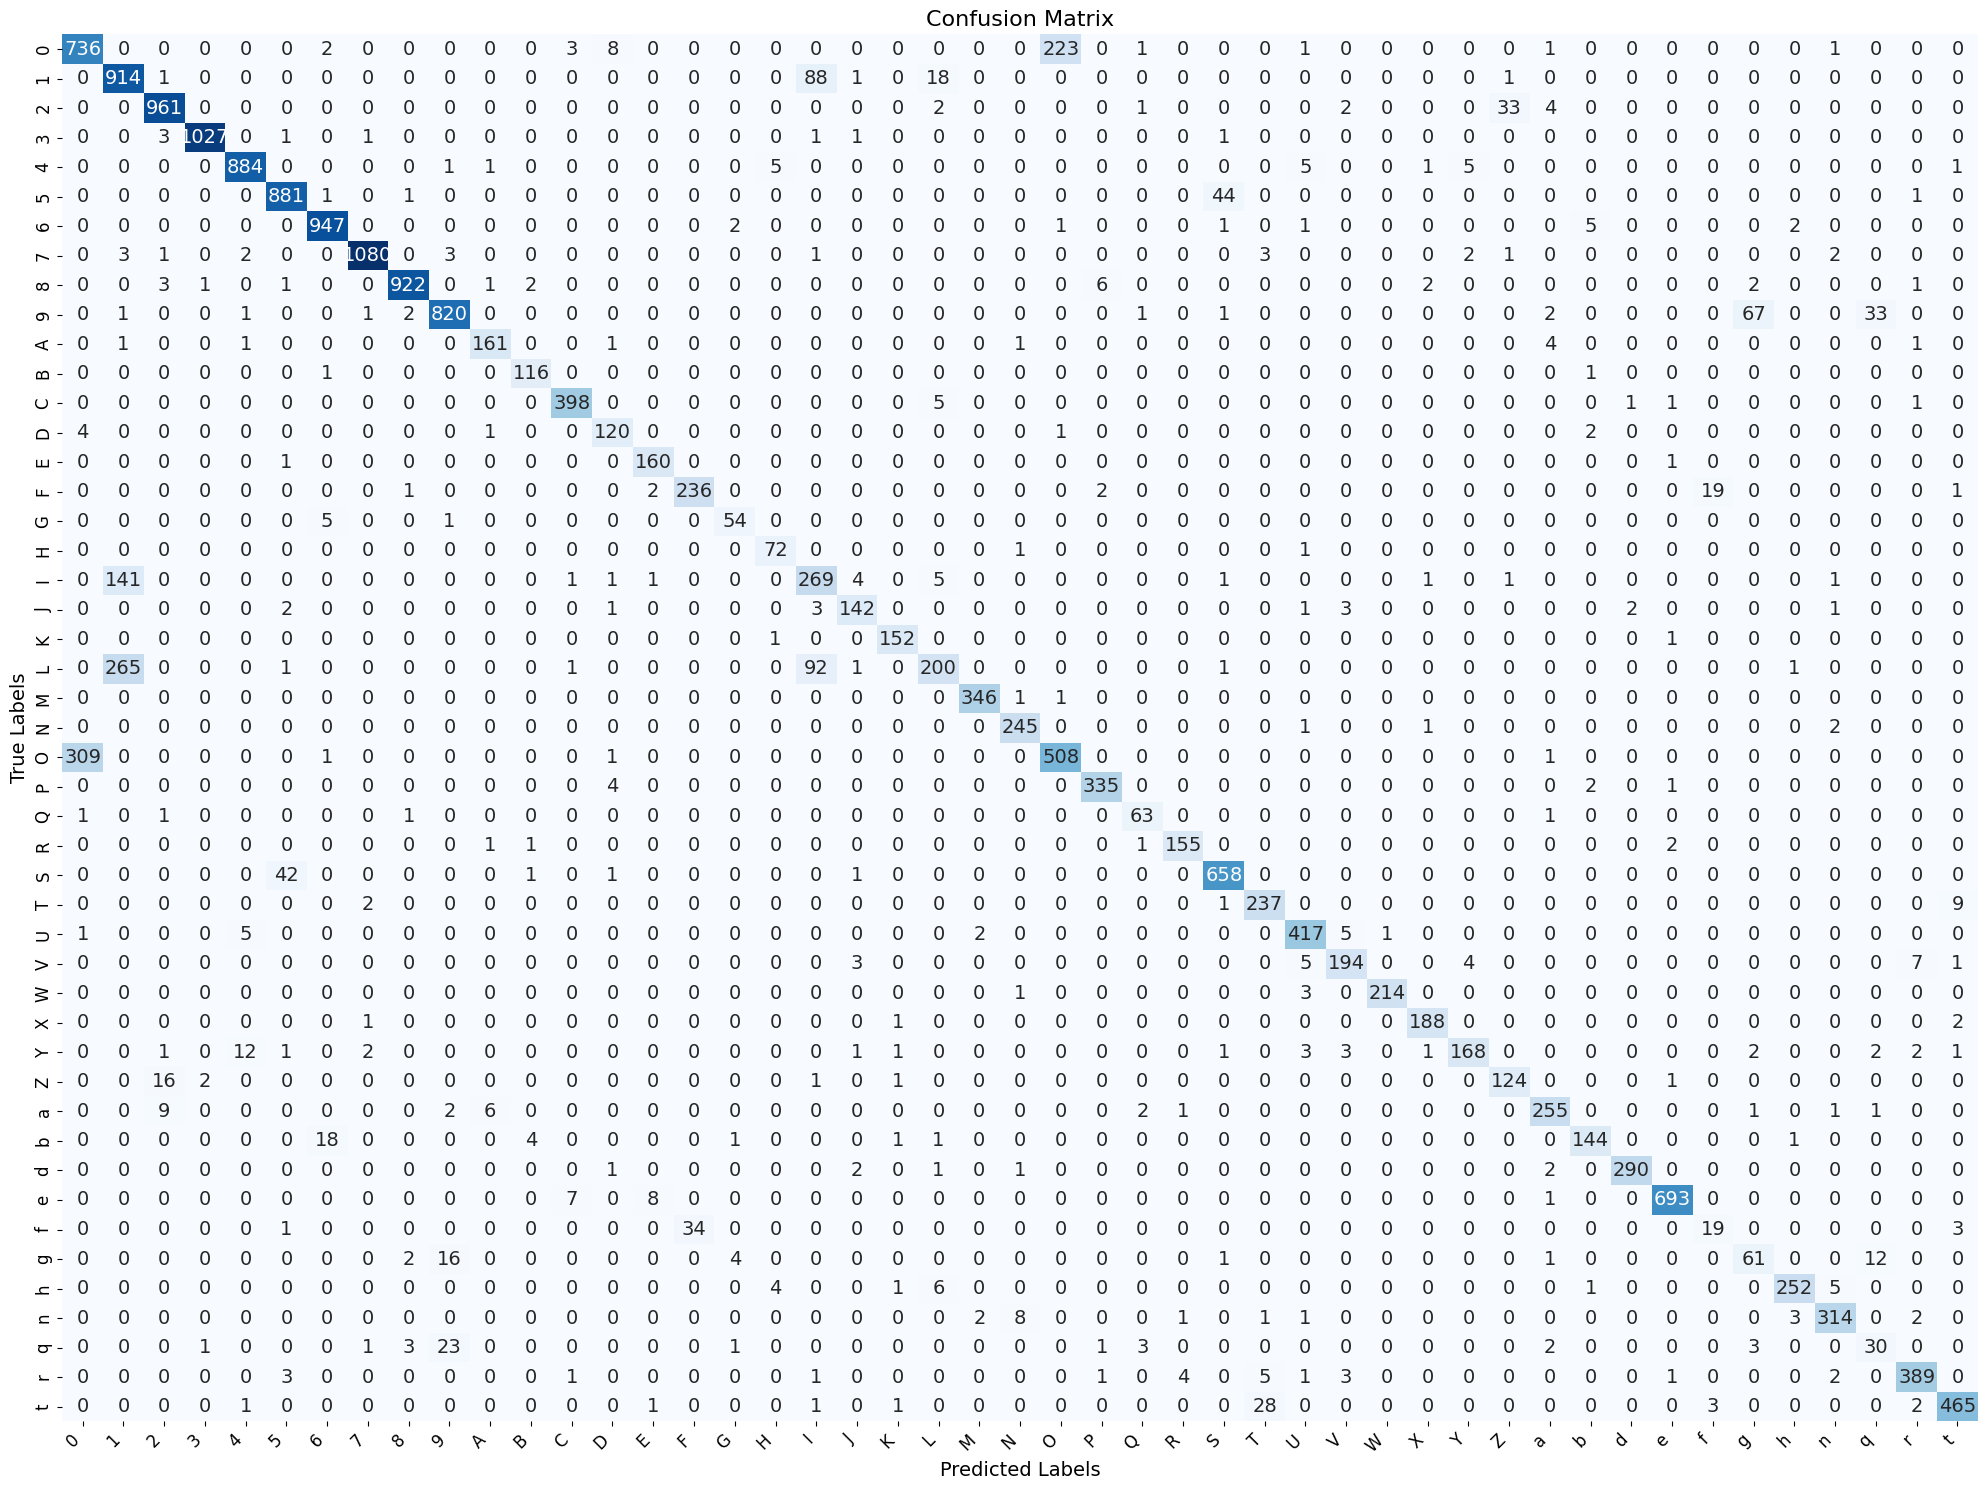

In [ ]:
display_conf(resnet_results["confusion_matrix"])

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.00005],
    'optimizer_name': ['Adam', 'SGD'],
    'momentum': [0.9, 0.95],  # Only applicable for SGD
    'weight_decay': [0.0, 1e-4],
    'scheduler_name': [None, 'StepLR', 'ReduceLROnPlateau'],
    'step_size': [5, 7],  # Only applicable for StepLR
    'gamma': [0.1, 0.5],  # Applicable for both StepLR and ReduceLROnPlateau
}

best_resnet_config, best_resnet_val_accuracy = run_hyperparameter_tuning(
    model_class=resnet,
    param_grid=param_grid,
    train_loader=train_loader,
    test_loader=test_loader,
    train_labels=train_labels,
    class_weights_dict=class_weights_dict,
    max_runs=20
)

# Print the best configuration and its validation accuracy
print(f"\nBest Configuration: {best_resnet_config}")
print(f"Best Validation Accuracy: {best_resnet_val_accuracy:.2f}%")

In [ ]:
vit_results = train_model(model=vit, train_loader=train_loader, test_loader=test_loader, train_labels=train_labels, class_weights_dict=class_weights_dict, num_epochs=20, learning_rate=5e-5)


In [ ]:
# use the same param grid for vit
best_vit_config, best_vit_val_accuracy = run_hyperparameter_tuning(
    model_class=resnet,
    param_grid=param_grid,
    train_loader=train_loader,
    test_loader=test_loader,
    train_labels=train_labels,
    class_weights_dict=class_weights_dict,
    max_runs=10
)

# Print the best configuration and its validation accuracy
print(f"\nBest Configuration: {best_vit_config}")
print(f"Best Validation Accuracy: {best_vit_val_accuracy:.2f}%")